# COSC 4P96: Semi-Supervised Learning with Neural Networks

## Assignment Overview

This notebook implements a complete pipeline for semi-supervised learning on the Fashion-MNIST dataset across four stages:

- **Stage 1**: Data Preparation and Preprocessing 
- **Stage 2**: Supervised Neural Network Baseline 
- **Stage 3**: Architecture Selection and Regularization 
- **Stage 4**: Semi-Supervised Learning with Consistency Regularization 

**Dataset**: Fashion-MNIST (70,000 samples, 10 classes)
**Data Split**: Test (10%) | Validation (10%) | Training Pool (80%)

---

# STAGE 1: Data Preparation and Preprocessing 

## Overview
This stage implements data loading, splitting, preprocessing, and augmentation for the Fashion-MNIST dataset.

### Key Implementations:
- Loads Fashion-MNIST (70,000 training samples)
- Splits data  into: Test (10%) | Validation (10%) | Training Pool (80%)
- From training pool: Labeled (20%) | Unlabeled (80%)
- Implements preprocessing methods
- Implements augmentation techniques

## Setup - Imports

We use PyTorch for model training and `torchvision` to load the FashionMNIST dataset.  
`DataLoader` handles batching/shuffling, and `Subset/random_split` are used to create labeled/unlabeled and train/validation splits.

In [1]:
import torch
from torch.utils.data import DataLoader, Subset, random_split
from torchvision import datasets, transforms

## Stage 1 — Dataset Loading & Basic Preprocessing

The FashionMNIST dataset is used for the coursework.  

- Training set: 60,000 images
- Test set: 10,000 images

In [2]:
transform_dataset = transforms.ToTensor()  

# Load FashionMNIST dataset
train_dataset = datasets.FashionMNIST(
    root="./data/raw",
    train=True,
    download=True,
    transform=transform_dataset
)

test_dataset = datasets.FashionMNIST(
    root="./data/raw",
    train=False,
    download=True,
    transform=transform_dataset
)

# Dataset size check
print("Train:", len(train_dataset))
print("Test :", len(test_dataset))

Train: 60000
Test : 10000


In [3]:

split_seed = torch.Generator().manual_seed(123)

train_pool_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_pool_size

train_pool_dataset, val_dataset = random_split(
    train_dataset,
    [train_pool_size, val_size],
    generator=split_seed
)

print(f"Train pool size: {len(train_pool_dataset)}")
print(f"Validation size: {len(val_dataset)}")

Train pool size: 48000
Validation size: 12000


### Compute dataset statistics for Z-score normalization

To apply Z-score normalization, we need the dataset mean (μ) and standard deviation (σ).
We compute these statistics over the training set after converting images to tensors.

These values are later used in `transforms.Normalize((μ,), (σ,))`.

In [4]:
# Compute dataset mean and std
temp_loader = DataLoader(train_dataset, batch_size=512)

pixel_sum = 0.0
pixel_squared_sum = 0.0
num_pixels = 0

for images, _ in temp_loader:
    pixel_sum += images.sum()
    pixel_squared_sum += (images ** 2).sum()
    num_pixels += images.numel()

mean = pixel_sum / num_pixels
std = torch.sqrt(pixel_squared_sum / num_pixels - mean ** 2)

print(f"Dataset mean: {mean:.4f}")
print(f"Dataset std : {std:.4f}")

Dataset mean: 0.2860
Dataset std : 0.3530


###  Define preprocessing transforms

Two preprocessing variants are implemented:

- **Min-Max scaling** using `ToTensor()`  
  (scales pixel values from 0–255 → 0–1)

- **Z-score normalization** using `Normalize((μ,), (σ,))`  
  (centers around 0 and scales to unit variance)

In [5]:
minmax_transform = transforms.ToTensor()

zscore_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((mean.item(),), (std.item(),))
])

### Create dataset versions for each preprocessing method

We load two versions of the dataset:
- `train_minmax`, `test_minmax` using Min-Max scaling
- `train_zscore`, `test_zscore` using Z-score normalization

This makes it easy to run controlled experiments comparing preprocessing methods.

In [6]:
train_minmax = datasets.FashionMNIST(
    root="./data/raw",
    train=True,
    download=False,
    transform=minmax_transform
)

train_zscore = datasets.FashionMNIST(
    root="./data/raw",
    train=True,
    download=False,
    transform=zscore_transform
)

test_minmax = datasets.FashionMNIST(
    root="./data/raw",
    train=False,
    download=False,
    transform=minmax_transform
)

test_zscore = datasets.FashionMNIST(
    root="./data/raw",
    train=False,
    download=False,
    transform=zscore_transform
)

###  Map Subset Indices to Preprocessing Variants

After splitting the dataset into train pool, validation, labeled, and unlabeled subsets,
we extract the corresponding indices from the original dataset.

These indices are then used to create consistent subsets for:
- Min-Max preprocessing
- Z-score preprocessing

This ensures that both preprocessing strategies use identical data splits,
allowing fair comparison between them.

In [7]:
# Extract original dataset indices
train_pool_indices = train_pool_dataset.indices
val_indices = val_dataset.indices

# Split train pool into labeled/unlabeled subsets (20% / 80%)
labeled_size = int(0.2 * len(train_pool_dataset))
unlabeled_size = len(train_pool_dataset) - labeled_size

labeled_dataset, unlabeled_dataset = random_split(
	train_pool_dataset,
	[labeled_size, unlabeled_size],
	generator=split_seed
)

# Map labeled/unlabeled indices back to original dataset indices
labeled_indices = [train_pool_indices[i] for i in labeled_dataset.indices]
unlabeled_indices = [train_pool_indices[i] for i in unlabeled_dataset.indices]


# Create Min-Max subsets
train_pool_minmax = Subset(train_minmax, train_pool_indices)
val_minmax = Subset(train_minmax, val_indices)
labeled_minmax = Subset(train_minmax, labeled_indices)
unlabeled_minmax = Subset(train_minmax, unlabeled_indices)


# Create Z-score subsets
train_pool_zscore = Subset(train_zscore, train_pool_indices)
val_zscore = Subset(train_zscore, val_indices)
labeled_zscore = Subset(train_zscore, labeled_indices)
unlabeled_zscore = Subset(train_zscore, unlabeled_indices)


# Final Dataset Split Summary
print("Subset Verification\n")

print("Train Pool:")
print(f"  Min-Max : {len(train_pool_minmax)}")
print(f"  Z-score : {len(train_pool_zscore)}\n")

print("Validation:")
print(f"  Min-Max : {len(val_minmax)}")
print(f"  Z-score : {len(val_zscore)}\n")

print("Labeled:")
print(f"  Min-Max : {len(labeled_minmax)}")
print(f"  Z-score : {len(labeled_zscore)}\n")

print("Unlabeled:")
print(f"  Min-Max : {len(unlabeled_minmax)}")
print(f"  Z-score : {len(unlabeled_zscore)}")

Subset Verification

Train Pool:
  Min-Max : 48000
  Z-score : 48000

Validation:
  Min-Max : 12000
  Z-score : 12000

Labeled:
  Min-Max : 9600
  Z-score : 9600

Unlabeled:
  Min-Max : 38400
  Z-score : 38400


### Sanity Check: Verify Preprocessing Consistency

We confirm that:
- The same sample has identical labels across preprocessing variants.
- Min-Max scaling produces values in [0, 1].
- Z-score normalization produces values centered around 0 with unit variance.

In [8]:
sample_minmax, label_minmax = labeled_minmax[0]
sample_zscore, label_zscore = labeled_zscore[0]

print(f"Labels identical: {label_minmax == label_zscore}")

print(f"Min-Max range: {float(sample_minmax.min()):.4f} to {float(sample_minmax.max()):.4f}")
print(f"Z-score range: {float(sample_zscore.min()):.4f} to {float(sample_zscore.max()):.4f}")
print(f"Z-score mean/std: {float(sample_zscore.mean()):.4f} , {float(sample_zscore.std()):.4f}")

Labels identical: True
Min-Max range: 0.0000 to 1.0000
Z-score range: -0.8103 to 2.0224
Z-score mean/std: -0.2459 , 0.9536


### Data Augmentation

To improve generalization and support semi-supervised learning, 
we apply data augmentation to the training data.

The augmentation pipeline includes:
- **Random horizontal flipping** (probability = 0.5)
- **Small random rotations** (-/+10 degrees)

These transformations introduce controlled variability in the input data, 
encouraging the model to learn more robust and invariant features.

Importantly:
- Augmentation is applied **only during training**
- Validation and test sets remain unmodified to ensure fair evaluation

Using the same dataset indices defined earlier, we create augmented subsets for:
- Train pool
- Labeled data
- Unlabeled data

This guarantees that:
- The data split remains identical
- Only the input transformation differs



In [ ]:
# Data augmentation 
augmentation_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),  
    transforms.RandomRotation(degrees=10),    
    transforms.ToTensor()
])

# Dataset with augmentation applied
train_augmented = datasets.FashionMNIST(
    root="./data/raw",
    train=True,
    download=False,
    transform=augmentation_transform
)

train_pool_augmented = Subset(train_augmented, train_pool_indices)
labeled_augmented = Subset(train_augmented, labeled_indices)
unlabeled_augmented = Subset(train_augmented, unlabeled_indices)



print(f"Augmented labeled samples: {len(labeled_augmented)}")
print(f"Augmented unlabeled samples: {len(unlabeled_augmented)}")

Augmented labeled samples: 9600
Augmented unlabeled samples: 38400


---

# STAGE 2: Supervised Neural Network Baseline

## Overview
This stage trains a supervised neural network using only labeled data to establish a baseline for semi-supervised methods.

### Key Requirements:
- **Architecture**: Hidden layers with ReLU activation, bias units, softmax output
- **Training**: Backpropagation, SGD with momentum, mini-batch (128)
- **Hyperparameters**: Learning rate η ∈ [0.001, 0.1], Momentum α ∈ [0.5, 0.99]
- **Weight Init**: Compare uniform, normal, He initialization
- **Early Stopping**: Monitor validation error with moving average criterion
- **Evaluation**: Report train/val curves, test accuracy, training time
- **Reproducibility**: Run 3 times with seeds {1, 123, 12345}

##  Training Utilities and Libraries

This section imports the core libraries used throughout the assignment:
- **NumPy** for numerical utilities
- **PyTorch** (`torch`, `nn`, `optim`) for model definition and training
- **Matplotlib** for plotting training/validation curves
- Standard Python modules for timing and reproducibility

In [11]:
import time, random, math
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import os, json
from datetime import datetime

## DataLoaders for Supervised Training

For supervised training (Stage 2), we use:

- **Labeled augmented data** for training  
- **Clean validation data** for early stopping  
- **Clean test data** for final evaluation  

Augmentation is applied only to training data to improve generalization,
while validation and test sets remain unmodified to ensure fair evaluation.

In [12]:
# Supervised training setup
train_dataset_supervised = labeled_augmented   # augmented labeled data
val_dataset_clean = val_minmax                # clean validation data
test_dataset_clean = test_minmax              # clean test data


batch_size = 128

train_loader = DataLoader(train_dataset_supervised, batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(val_dataset_clean,       batch_size=batch_size, shuffle=False)
test_loader  = DataLoader(test_dataset_clean,      batch_size=batch_size, shuffle=False)

# Verification
print(f"Train batches: {len(train_loader)}")
print(f"Validation batches: {len(val_loader)}")
print(f"Test batches: {len(test_loader)}")

Train batches: 75
Validation batches: 94
Test batches: 79


## Model Architecture

We implement a feedforward neural network (Multi-Layer Perceptron).

Architecture:
- Input: 28×28 grayscale image (flattened to 784)
- Hidden Layer 1: 256 units + ReLU
- Hidden Layer 2: 128 units + ReLU
- Output Layer: 10 units (one per class)

Bias terms are included in all linear layers.

The output layer produces raw logits.  
Softmax is applied implicitly inside `CrossEntropyLoss`.

In [13]:
class MLP(nn.Module):

    def __init__(self):
        super(MLP, self).__init__()

        self.network = nn.Sequential(
            nn.Flatten(),                
            nn.Linear(784, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 10)           
        )

    def forward(self, x):
        return self.network(x)


# Instantiate model
model = MLP()
print(model)

MLP(
  (network): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=256, bias=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=128, bias=True)
    (4): ReLU()
    (5): Linear(in_features=128, out_features=10, bias=True)
  )
)


## Reproducibility — Random Seed Control

To ensure reproducible experiments across multiple runs, 
we fix the random seed for:

- Python's `random`
- NumPy
- PyTorch (CPU and GPU)

We also enable deterministic behavior in cuDNN.

This is required for fair comparison across different random seeds
(e.g., {1, 123, 12345}).

In [ ]:
"""
    Set random seeds for reproducibility across all libraries.
    Args:seed (int): Random seed value       
"""
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

## Weight Initialization Strategies

We compare three weight initialization methods:

1. **Uniform (fan-in based)**  
   Initializes weights in the range [-1/√fan_in, 1/√fan_in]

2. **Small Normal Distribution**  
   Initializes weights using N(0, 0.01)

3. **He (Kaiming) Initialization**  
   Designed for ReLU activations; helps maintain variance across layers

Bias terms are initialized to zero in all cases.

Proper initialization improves convergence speed and training stability.

In [15]:
"""
    Initialize weights of Linear layers in the model.

    Supported modes:
        - 'uniform_fanin' : Uniform[-1/sqrt(fan_in), 1/sqrt(fan_in)]
        - 'normal_small'  : Normal(mean=0, std=0.01)
        - 'he'            : Kaiming (He) initialization for ReLU
    Args:
        model (nn.Module): PyTorch model
        mode (str): Initialization strategy
"""
def init_weights(model: nn.Module, mode: str = "he"):

    for layer in model.modules():

        if isinstance(layer, nn.Linear):
            fan_in = layer.weight.size(1)

            if mode == "uniform_fanin":
                bound = 1.0 / math.sqrt(fan_in)
                nn.init.uniform_(layer.weight, -bound, bound)

            elif mode == "normal_small":
                nn.init.normal_(layer.weight, mean=0.0, std=0.01)

            elif mode == "he":
                nn.init.kaiming_normal_(layer.weight, nonlinearity="relu")

            else:
                raise ValueError(f"Unknown initialization mode: {mode}")

            # Initialize bias to zero
            if layer.bias is not None:
                nn.init.zeros_(layer.bias)

## Evaluation Function

This helper function evaluates the model on a given dataset.

It computes:
- Average loss
- Classification accuracy (%)

The model is set to evaluation mode and gradients are disabled,
ensuring correct behavior for validation and test evaluation.

In [16]:
"""
    Evaluate model performance on a dataset.

    Args:
        model (nn.Module): Trained model
        dataloader (DataLoader): Validation or test loader
        criterion (nn.Module): Loss function

    Returns:
        avg_loss (float): Mean loss across batches
        accuracy (float): Classification accuracy in percentage
    """

def evaluate_acc_loss(model: nn.Module,dataloader: DataLoader,criterion: nn.Module) -> tuple[float, float]:
    model.eval()

    total_samples = 0
    correct_predictions = 0
    total_loss = 0.0

    with torch.no_grad():
        for inputs, targets in dataloader:

            logits = model(inputs)
            loss = criterion(logits, targets)

            total_loss += loss.item()

            predictions = torch.argmax(logits, dim=1)

            total_samples += targets.size(0)
            correct_predictions += (predictions == targets).sum().item()

    avg_loss = total_loss / len(dataloader)
    accuracy = 100.0 * correct_predictions / total_samples

    return avg_loss, accuracy

## Stage 2 — Supervised Training Runner (Baseline)

This function trains the MLP using **only the labeled subset**, as required for the supervised baseline.

Features included:
- SGD optimizer with momentum
- Configurable learning rate and momentum
- Weight initialization strategies (uniform_fanin, normal_small, he)
- Early stopping using the assignment rule based on validation error statistics
- Tracking training/validation loss and accuracy each epoch
- Reporting training time and final test accuracy

## Helper Method

In [ ]:
def make_run_id(stage: str, seed: int, **params) -> str:
    """
    Create a readable run id like:
    stage2_seed123_init-he_lr0.01_m0.9_win5
    """
    parts = [stage, f"seed{seed}"]
    for k, v in params.items():
        if isinstance(v, float):
            parts.append(f"{k}{v:g}")   
        else:
            parts.append(f"{k}{v}")
    return "_".join(parts)


def ensure_dir(path: str):
    os.makedirs(path, exist_ok=True)

##  Supervised Runner with  Logging

This version of `run_stage2()`:
- prints the run configuration at the start
- saves per-epoch metrics to CSV
- saves a summary JSON for the run
- optionally saves the best model checkpoint
- supports `verbose=False` to avoid notebook spam

In [18]:
def run_stage2(
    seed: int,
    init_mode: str,
    lr: float,
    momentum: float,
    max_epochs: int,
    early_stop_window: int,
    verbose: bool,
    save_dir: str,
    save_model: bool
) -> dict:
    """
    Train a supervised baseline model using only labeled data.

    Logging:
        - Saves per-epoch metrics to CSV
        - Saves final summary to JSON
        - Optionally saves best model checkpoint

    Returns:
        dict with metrics + history + file paths
    """

    set_seed(seed)
    ensure_dir(save_dir)

    run_id = make_run_id(
        "stage2",
        seed,
        init=init_mode,
        lr=lr,
        m=momentum,
        win=early_stop_window
    )

    csv_path = os.path.join(save_dir, f"{run_id}_history.csv")
    json_path = os.path.join(save_dir, f"{run_id}_summary.json")
    ckpt_path = os.path.join(save_dir, f"{run_id}_best.pt")

    #Print run config
    print("\n" )
    print("STAGE 2 RUN CONFIG")
    print("-" * 70)
    print(f"Run ID            : {run_id}")
    print(f"Seed              : {seed}")
    print(f"Init              : {init_mode}")
    print(f"Learning rate     : {lr}")
    print(f"Momentum          : {momentum}")
    print(f"Max epochs        : {max_epochs}")
    print(f"Early-stop window : {early_stop_window}")
   

    model = MLP()
    init_weights(model, init_mode)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum)

    history = {
        "train_loss": [],
        "train_acc": [],
        "val_loss": [],
        "val_acc": []
    }

    # Write CSV header once
    with open(csv_path, "w") as f:
        f.write("epoch,train_loss,train_acc,val_loss,val_acc\n")

    val_errors = []
    best_val_acc = -1.0
    best_state = None
    stopped_epoch = max_epochs

    start_time = time.time()

    for epoch in range(1, max_epochs + 1):
        model.train()

        train_loss_sum = 0.0
        train_total = 0
        train_correct = 0

        for inputs, targets in train_loader:
            optimizer.zero_grad()

            logits = model(inputs)
            loss = criterion(logits, targets)

            loss.backward()
            optimizer.step()

            train_loss_sum += loss.item()
            preds = torch.argmax(logits, dim=1)

            train_total += targets.size(0)
            train_correct += (preds == targets).sum().item()

        train_loss = train_loss_sum / len(train_loader)
        train_acc = 100.0 * train_correct / train_total

        val_loss, val_acc = evaluate_acc_loss(model, val_loader, criterion)

        history["train_loss"].append(train_loss)
        history["train_acc"].append(train_acc)
        history["val_loss"].append(val_loss)
        history["val_acc"].append(val_acc)

        # append to CSV each epoch
        with open(csv_path, "a") as f:
            f.write(f"{epoch},{train_loss:.6f},{train_acc:.4f},{val_loss:.6f},{val_acc:.4f}\n")

        # track best model
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_state = {k: v.cpu().clone() for k, v in model.state_dict().items()}
            if save_model:
                torch.save(best_state, ckpt_path)

        # early stopping rule on validation error
        val_error = 1.0 - (val_acc / 100.0)
        val_errors.append(val_error)

        if len(val_errors) >= early_stop_window + 1:
            recent = np.array(val_errors[-(early_stop_window + 1):-1])
            if val_error > (recent.mean() + recent.std()):
                stopped_epoch = epoch
                if verbose:
                    print(f"EARLY STOP at epoch {epoch} | Train Acc: {train_acc:.2f}% | Val Acc: {val_acc:.2f}%")
                break

        if verbose:
            print(f"Epoch {epoch}/{max_epochs} | Train Acc: {train_acc:.2f}% | Val Acc: {val_acc:.2f}%")

    train_time_sec = time.time() - start_time

    # restore best model
    model.load_state_dict(best_state)

    # test
    _, test_acc = evaluate_acc_loss(model, test_loader, nn.CrossEntropyLoss())

    summary = {
        "run_id": run_id,
        "stage": "stage2",
        "seed": seed,
        "init_mode": init_mode,
        "lr": lr,
        "momentum": momentum,
        "max_epochs": max_epochs,
        "early_stop_window": early_stop_window,
        "stopped_epoch": stopped_epoch,
        "best_val_acc": best_val_acc,
        "test_acc": float(test_acc),
        "train_time_sec": float(train_time_sec),
        "history_csv": csv_path,
        "summary_json": json_path,
        "best_model_path": ckpt_path if save_model else None,
        "timestamp": datetime.now().isoformat(timespec="seconds")
    }

    with open(json_path, "w") as f:
        json.dump(summary, f, indent=2)

    return {
        "seed": seed,
        "init_mode": init_mode,
        "lr": lr,
        "momentum": momentum,
        "stopped_epoch": stopped_epoch,
        "best_val_acc": best_val_acc,
        "test_acc": test_acc,
        "train_time_sec": train_time_sec,
        "history": history,
        "run_id": run_id,
        "history_csv": csv_path,
        "summary_json": json_path,
        "best_model_path": ckpt_path if save_model else None
    }

## Multi-Seed Evaluation

To ensure robustness, we repeat the supervised baseline training 
using three different random seeds: {1, 123, 12345}.

We report:
- Early stopping epoch
- Best validation accuracy
- Final test accuracy

The final baseline result is reported as:
Mean ± Standard Deviation

In [ ]:
# Stage 2 — Multi-seed baseline evaluation
save_dir = "./results/stage2_multiseed"
os.makedirs(save_dir, exist_ok=True)

seed_list = [1, 123, 12345]
test_accuracies = []
train_times = []
run_ids = []
histories = {}   

for seed in seed_list:
    result = run_stage2(
        seed=seed,
        init_mode="he",
        lr=0.01,
        momentum=0.9,
        max_epochs=50,
        early_stop_window=5,
        verbose=False,
        save_dir="./results/stage2",  
        save_model=True
    )

    test_accuracies.append(result["test_acc"])
    train_times.append(result["train_time_sec"])
    run_ids.append(result["run_id"])
    histories[seed] = result["history"]  

    print(
        f"Seed {seed} | "
        f"stop@{result['stopped_epoch']} | "
        f"best val {result['best_val_acc']:.2f}% | "
        f"test {result['test_acc']:.2f}%"
    )

baseline_mean = float(np.mean(test_accuracies))
baseline_std = float(np.std(test_accuracies, ddof=1))
mean_time = float(np.mean(train_times))

print(f"\nBaseline Test Accuracy: {baseline_mean:.2f}% ± {baseline_std:.2f}%")
print(f"Average Training Time : {mean_time:.2f} sec")

# Save summary CSV
csv_path = os.path.join(save_dir, "stage2_multiseed_summary.csv")

with open(csv_path, "w") as f:
    f.write("seed,test_acc,train_time_sec,run_id\n")
    for s, acc, t, rid in zip(seed_list, test_accuracies, train_times, run_ids):
        f.write(f"{s},{acc:.4f},{t:.4f},{rid}\n")
    f.write(f"\nmean,{baseline_mean:.4f},,\n")
    f.write(f"std,{baseline_std:.4f},,\n")

print(f"Saved CSV: {csv_path}")

# Save summary JSON
json_path = os.path.join(save_dir, "stage2_multiseed_summary.json")

summary_data = {
    "stage": "stage2_baseline",
    "seeds": seed_list,
    "test_accuracies": test_accuracies,
    "mean_test_accuracy": baseline_mean,
    "std_test_accuracy": baseline_std,
    "mean_train_time_sec": mean_time,
    "run_ids": run_ids
}

with open(json_path, "w") as f:
    json.dump(summary_data, f, indent=2)

print(f"Saved JSON: {json_path}")



STAGE 2 RUN CONFIG
----------------------------------------------------------------------
Run ID            : stage2_seed1_inithe_lr0.01_m0.9_win5
Seed              : 1
Init              : he
Learning rate     : 0.01
Momentum          : 0.9
Max epochs        : 50
Early-stop window : 5
Seed 1 | stop@15 | best val 84.29% | test 82.66%


STAGE 2 RUN CONFIG
----------------------------------------------------------------------
Run ID            : stage2_seed123_inithe_lr0.01_m0.9_win5
Seed              : 123
Init              : he
Learning rate     : 0.01
Momentum          : 0.9
Max epochs        : 50
Early-stop window : 5
Seed 123 | stop@18 | best val 84.68% | test 83.32%


STAGE 2 RUN CONFIG
----------------------------------------------------------------------
Run ID            : stage2_seed12345_inithe_lr0.01_m0.9_win5
Seed              : 12345
Init              : he
Learning rate     : 0.01
Momentum          : 0.9
Max epochs        : 50
Early-stop window : 5
Seed 12345 | stop@17 | b

## Graph Plotation


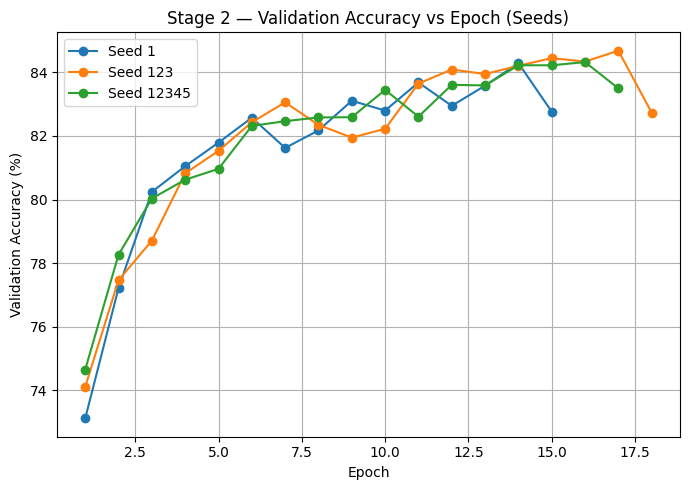

Saved plot: ./results/stage2_multiseed/stage2_multiseed_val_accuracy.png


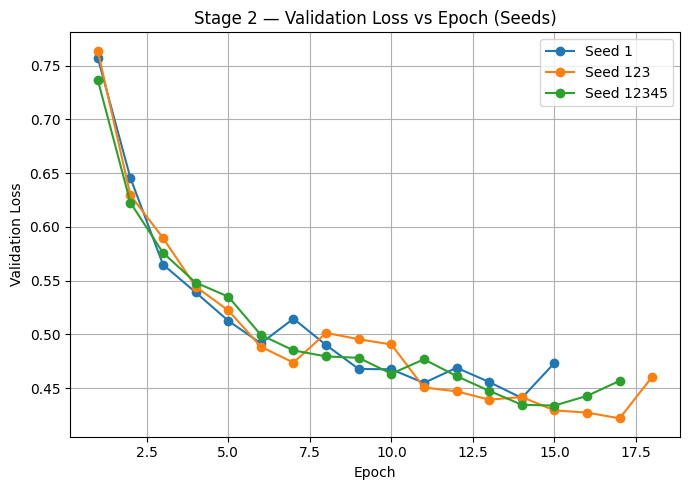

Saved plot: ./results/stage2_multiseed/stage2_multiseed_val_loss.png


In [ ]:
# Plot 1: Validation Accuracy Curves (per seed)
plt.figure(figsize=(7,5))

for seed in seed_list:
    val_acc = histories[seed]["val_acc"]
    plt.plot(range(1, len(val_acc) + 1), val_acc, marker='o', label=f"Seed {seed}")

plt.xlabel("Epoch")
plt.ylabel("Validation Accuracy (%)")
plt.title("Stage 2 — Validation Accuracy vs Epoch (Seeds)")
plt.grid(True)
plt.legend()
plt.tight_layout()

val_acc_path = os.path.join(save_dir, "stage2_multiseed_val_accuracy.png")
plt.savefig(val_acc_path, dpi=300)
plt.show()
print(f"Saved plot: {val_acc_path}")


# Plot 2: Validation Loss Curves (per seed)
plt.figure(figsize=(7,5))

for seed in seed_list:
    val_loss = histories[seed]["val_loss"]
    plt.plot(range(1, len(val_loss) + 1), val_loss, marker='o', label=f"Seed {seed}")

plt.xlabel("Epoch")
plt.ylabel("Validation Loss")
plt.title("Stage 2 — Validation Loss vs Epoch (Seeds)")
plt.grid(True)
plt.legend()
plt.tight_layout()

val_loss_path = os.path.join(save_dir, "stage2_multiseed_val_loss.png")
plt.savefig(val_loss_path, dpi=300)
plt.show()
print(f"Saved plot: {val_loss_path}")

## Hyperparameter Exploration

We explore the effect of:

- Learning rate (η)
- Momentum (α)
- Weight initialization strategy

All experiments are run using a fixed seed (123) 
to isolate the effect of each hyperparameter.

In [ ]:
# Explore the effect of Learning Rate
save_dir = "./results/stage2_lr_comparison"
os.makedirs(save_dir, exist_ok=True)

learning_rates = [0.001, 0.01, 0.1]

histories = {}
test_accuracies = {}
stopped_epochs = {}

print("=" * 70)
print("STAGE 2 — LEARNING RATE COMPARISON")
print("=" * 70)

# Run Experiments
for lr in learning_rates:
    result = run_stage2(
        seed=123,
        init_mode="he",
        lr=lr,
        momentum=0.9,
        max_epochs=50,
        early_stop_window=5,
        verbose=False,
        save_dir="./results/stage2",
        save_model=True
    )

    histories[lr] = result["history"]
    test_accuracies[lr] = result["test_acc"]
    stopped_epochs[lr] = result["stopped_epoch"]

    print(
        f"LR {lr:<6g} | "
        f"stop@{result['stopped_epoch']:<2d} | "
        f"best val {result['best_val_acc']:.2f}% | "
        f"test {result['test_acc']:.2f}%"
    )

# Save Summary CSV
csv_path = os.path.join(save_dir, "stage2_lr_summary.csv")

with open(csv_path, "w") as f:
    f.write("learning_rate,test_acc,stopped_epoch\n")
    for lr in learning_rates:
        f.write(f"{lr},{test_accuracies[lr]:.4f},{stopped_epochs[lr]}\n")

print(f"\nSaved CSV: {csv_path}")

# Save Summary JSON
json_path = os.path.join(save_dir, "stage2_lr_summary.json")

summary_data = {
    "stage": "stage2_learning_rate_comparison",
    "learning_rates": learning_rates,
    "test_accuracies": test_accuracies,
    "stopped_epochs": stopped_epochs
}

with open(json_path, "w") as f:
    json.dump(summary_data, f, indent=2)

print(f"Saved JSON: {json_path}")

STAGE 2 — LEARNING RATE COMPARISON


STAGE 2 RUN CONFIG
----------------------------------------------------------------------
Run ID            : stage2_seed123_inithe_lr0.001_m0.9_win5
Seed              : 123
Init              : he
Learning rate     : 0.001
Momentum          : 0.9
Max epochs        : 50
Early-stop window : 5
LR 0.001  | stop@50 | best val 82.89% | test 81.21%


STAGE 2 RUN CONFIG
----------------------------------------------------------------------
Run ID            : stage2_seed123_inithe_lr0.01_m0.9_win5
Seed              : 123
Init              : he
Learning rate     : 0.01
Momentum          : 0.9
Max epochs        : 50
Early-stop window : 5
LR 0.01   | stop@18 | best val 84.68% | test 83.32%


STAGE 2 RUN CONFIG
----------------------------------------------------------------------
Run ID            : stage2_seed123_inithe_lr0.1_m0.9_win5
Seed              : 123
Init              : he
Learning rate     : 0.1
Momentum          : 0.9
Max epochs        : 50
Early-s

## Graph Plotation

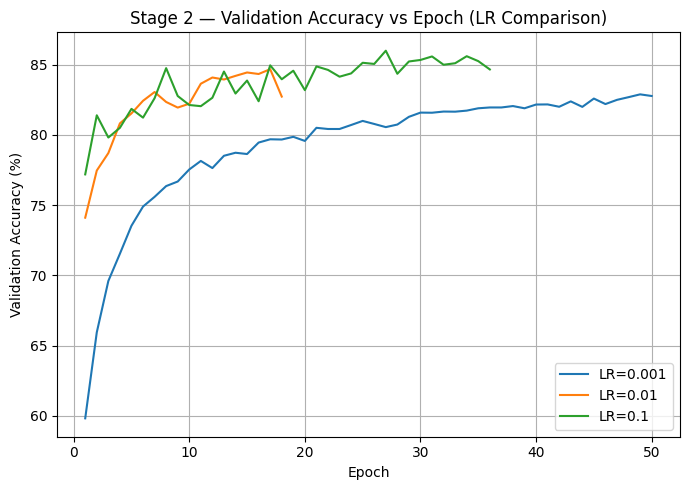

Saved plot: ./results/stage2_lr_comparison/stage2_lr_val_accuracy.png


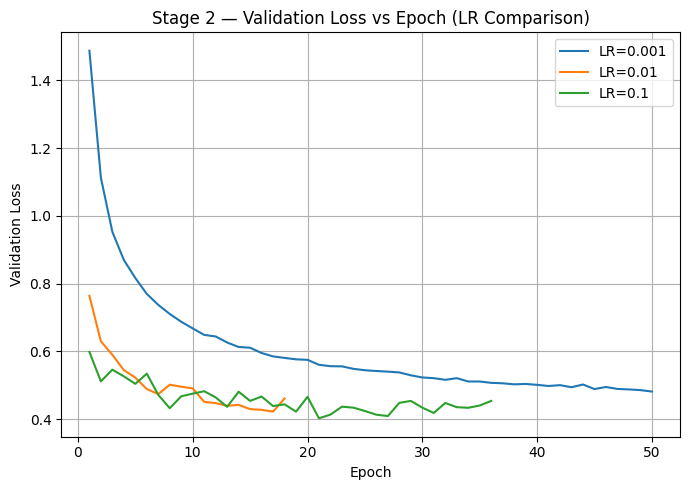

Saved plot: ./results/stage2_lr_comparison/stage2_lr_val_loss.png


In [ ]:
# Plot 1 — Validation Accuracy
plt.figure(figsize=(7,5))

for lr in learning_rates:
    val_acc = histories[lr]["val_acc"]
    plt.plot(range(1, len(val_acc)+1), val_acc, label=f"LR={lr}")

plt.xlabel("Epoch")
plt.ylabel("Validation Accuracy (%)")
plt.title("Stage 2 — Validation Accuracy vs Epoch (LR Comparison)")
plt.legend()
plt.grid(True)
plt.tight_layout()

val_acc_path = os.path.join(save_dir, "stage2_lr_val_accuracy.png")
plt.savefig(val_acc_path, dpi=300)
plt.show()

print(f"Saved plot: {val_acc_path}")

# --------------------------------------------------
# Plot 2 — Validation Loss
# --------------------------------------------------

plt.figure(figsize=(7,5))

for lr in learning_rates:
    val_loss = histories[lr]["val_loss"]
    plt.plot(range(1, len(val_loss)+1), val_loss, label=f"LR={lr}")

plt.xlabel("Epoch")
plt.ylabel("Validation Loss")
plt.title("Stage 2 — Validation Loss vs Epoch (LR Comparison)")
plt.legend()
plt.grid(True)
plt.tight_layout()

val_loss_path = os.path.join(save_dir, "stage2_lr_val_loss.png")
plt.savefig(val_loss_path, dpi=300)
plt.show()

print(f"Saved plot: {val_loss_path}")

In [ ]:
# Explore the effect of Momentum
save_dir = "./results/stage2_momentum_comparison"
os.makedirs(save_dir, exist_ok=True)

momentum_values = [0.5, 0.9, 0.99]

histories = {}
summary_rows = []

print("Stage 2 — Momentum Comparison\n")

for m in momentum_values:
    result = run_stage2(
        seed=123,
        init_mode="he",
        lr=0.01,
        momentum=m,
        max_epochs=50,
        early_stop_window=5,
        verbose=False,
        save_dir="./results/stage2",
        save_model=True

    )

    histories[m] = result["history"]

    summary_rows.append({
        "momentum": m,
        "test_acc": result["test_acc"],
        "best_val_acc": result["best_val_acc"],
        "stopped_epoch": result["stopped_epoch"]
    })

    print(
        f"Momentum={m} | "
        f"stop@{result['stopped_epoch']} | "
        f"best val {result['best_val_acc']:.2f}% | "
        f"test {result['test_acc']:.2f}%"
    )

# Save CSV
csv_path = os.path.join(save_dir, "momentum_summary.csv")
with open(csv_path, "w") as f:
    f.write("momentum,test_acc,best_val_acc,stopped_epoch\n")
    for row in summary_rows:
        f.write(f"{row['momentum']},{row['test_acc']:.4f},{row['best_val_acc']:.4f},{row['stopped_epoch']}\n")

# Save JSON
json_path = os.path.join(save_dir, "momentum_summary.json")
with open(json_path, "w") as f:
    json.dump(summary_rows, f, indent=2)

print(f"\nSaved results to: {save_dir}")

Stage 2 — Momentum Comparison



STAGE 2 RUN CONFIG
----------------------------------------------------------------------
Run ID            : stage2_seed123_inithe_lr0.01_m0.5_win5
Seed              : 123
Init              : he
Learning rate     : 0.01
Momentum          : 0.5
Max epochs        : 50
Early-stop window : 5
Momentum=0.5 | stop@28 | best val 82.79% | test 81.56%


STAGE 2 RUN CONFIG
----------------------------------------------------------------------
Run ID            : stage2_seed123_inithe_lr0.01_m0.9_win5
Seed              : 123
Init              : he
Learning rate     : 0.01
Momentum          : 0.9
Max epochs        : 50
Early-stop window : 5
Momentum=0.9 | stop@18 | best val 84.68% | test 83.32%


STAGE 2 RUN CONFIG
----------------------------------------------------------------------
Run ID            : stage2_seed123_inithe_lr0.01_m0.99_win5
Seed              : 123
Init              : he
Learning rate     : 0.01
Momentum          : 0.99
Max epochs        : 50
Ear

## Graph PLotation

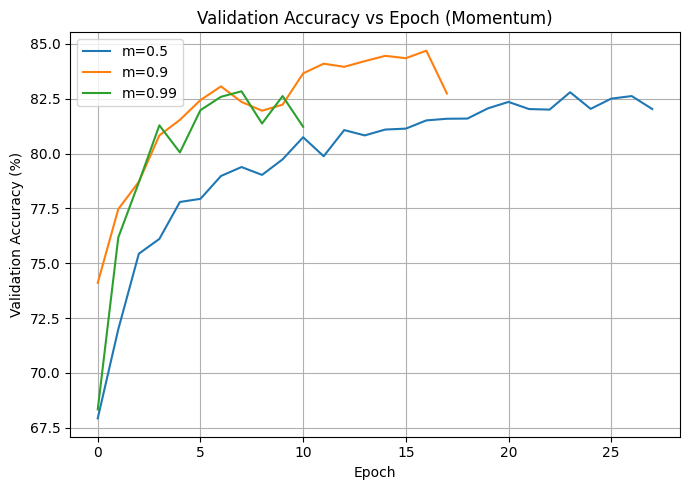

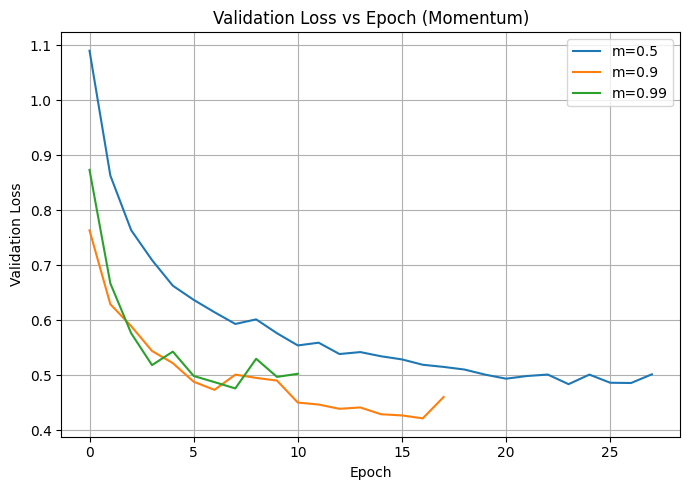

In [31]:
# Validation Accuracy
plt.figure(figsize=(7,5))
for m in momentum_values:
    plt.plot(histories[m]["val_acc"], label=f"m={m}")

plt.xlabel("Epoch")
plt.ylabel("Validation Accuracy (%)")
plt.title("Validation Accuracy vs Epoch (Momentum)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig(os.path.join(save_dir, "momentum_val_accuracy.png"), dpi=300)
plt.show()


# Validation Loss
plt.figure(figsize=(7,5))
for m in momentum_values:
    plt.plot(histories[m]["val_loss"], label=f"m={m}")

plt.xlabel("Epoch")
plt.ylabel("Validation Loss")
plt.title("Validation Loss vs Epoch (Momentum)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig(os.path.join(save_dir, "momentum_val_loss.png"), dpi=300)
plt.show()

### Initialization Strategy Comparison

We compare three weight initialization methods while keeping all other
hyperparameters fixed (seed=123, lr=0.01, momentum=0.9).

This isolates the effect of initialization on convergence and performance.

In [ ]:

save_dir = "./results/stage2_init_comparison"
os.makedirs(save_dir, exist_ok=True)

init_methods = ["uniform_fanin", "normal_small", "he"]
histories = {}
summary_rows = []

print("Stage 2 — Initialization Comparison\n")

for init_mode in init_methods:
    result = run_stage2(
        seed=123,
        init_mode=init_mode,
        lr=0.01,
        momentum=0.9,
        max_epochs=50,
        early_stop_window=5,
        verbose=False,
        save_dir="./results/stage2",   
        save_model=True 
    )

    histories[init_mode] = result["history"]

    summary_rows.append({
        "init_mode": init_mode,
        "test_acc": result["test_acc"],
        "best_val_acc": result["best_val_acc"],
        "stopped_epoch": result["stopped_epoch"]
    })

    print(
        f"Init={init_mode:<14} | "
        f"stop@{result['stopped_epoch']} | "
        f"best val {result['best_val_acc']:.2f}% | "
        f"test {result['test_acc']:.2f}%"
    )

# Save CSV
csv_path = os.path.join(save_dir, "initialization_summary.csv")
with open(csv_path, "w") as f:
    f.write("init_mode,test_acc,best_val_acc,stopped_epoch\n")
    for row in summary_rows:
        f.write(f"{row['init_mode']},{row['test_acc']:.4f},{row['best_val_acc']:.4f},{row['stopped_epoch']}\n")

# Save JSON
json_path = os.path.join(save_dir, "initialization_summary.json")
with open(json_path, "w") as f:
    json.dump(summary_rows, f, indent=2)

print(f"\nSaved results to: {save_dir}")

Stage 2 — Initialization Comparison



STAGE 2 RUN CONFIG
----------------------------------------------------------------------
Run ID            : stage2_seed123_inituniform_fanin_lr0.01_m0.9_win5
Seed              : 123
Init              : uniform_fanin
Learning rate     : 0.01
Momentum          : 0.9
Max epochs        : 50
Early-stop window : 5
Init=uniform_fanin  | stop@18 | best val 82.41% | test 81.12%


STAGE 2 RUN CONFIG
----------------------------------------------------------------------
Run ID            : stage2_seed123_initnormal_small_lr0.01_m0.9_win5
Seed              : 123
Init              : normal_small
Learning rate     : 0.01
Momentum          : 0.9
Max epochs        : 50
Early-stop window : 5
Init=normal_small   | stop@36 | best val 84.15% | test 83.14%


STAGE 2 RUN CONFIG
----------------------------------------------------------------------
Run ID            : stage2_seed123_inithe_lr0.01_m0.9_win5
Seed              : 123
Init              : he
Learning rate  

## Graph PLotation

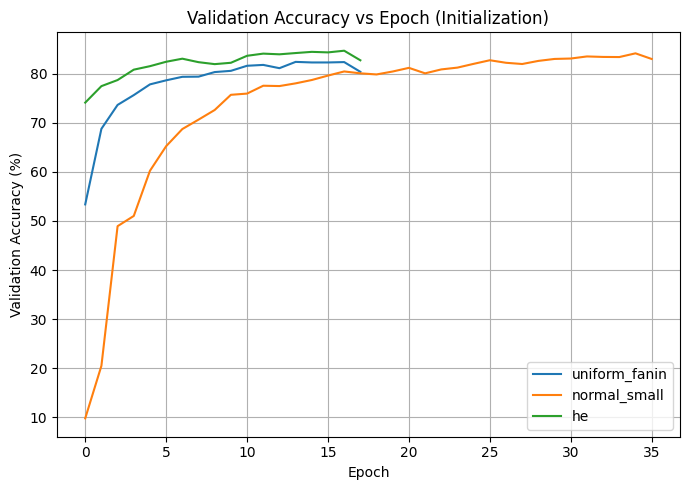

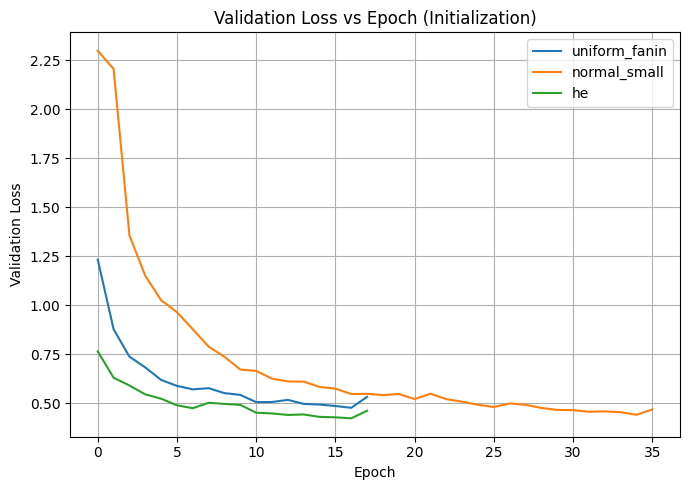

In [33]:
plt.figure(figsize=(7,5))

for init_mode in init_methods:
    plt.plot(histories[init_mode]["val_acc"], label=init_mode)

plt.xlabel("Epoch")
plt.ylabel("Validation Accuracy (%)")
plt.title("Validation Accuracy vs Epoch (Initialization)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig(os.path.join(save_dir, "init_val_accuracy.png"), dpi=300)
plt.show()

plt.figure(figsize=(7,5))

for init_mode in init_methods:
    plt.plot(histories[init_mode]["val_loss"], label=init_mode)

plt.xlabel("Epoch")
plt.ylabel("Validation Loss")
plt.title("Validation Loss vs Epoch (Initialization)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig(os.path.join(save_dir, "init_val_loss.png"), dpi=300)
plt.show()

---

# STAGE 3: Architecture Selection and Regularization (20 marks)

## Overview
This stage implements regularization techniques to improve the baseline model and reduce overfitting.

### Implemented Techniques:

#### **Technique A: Dropout Regularization**
- Randomly sets hidden unit activations to zero during training
- Reduces co-adaptation of neurons and improves generalization
- Experiment with p ∈ {0.1, 0.25, 0.5}
- Applied after each hidden layer

#### **Technique B: Weight Decay Regularization (L2)**
- Adds L2 penalty to loss: L = L_CE + (λ/2) Σ w_i²
- Encourages smaller weights, reducing model complexity
- Experiment with λ ∈ {10⁻⁵, 10⁻⁴, 10⁻³, 10⁻²}
- Tracks weight magnitudes during training

### Evaluation:
Compare against baseline across multiple seeds {1, 123, 12345}

## MLP with Dropout Regularization

To reduce overfitting, we extend the baseline MLP by adding Dropout layers
after each hidden layer.

Dropout randomly sets a fraction `p` of activations to zero during training.
This prevents co-adaptation of neurons and improves generalization.

Dropout is automatically disabled during evaluation (`model.eval()`).

In [ ]:
class MLPDropout(nn.Module):
    """
    MLP with Dropout regularization.
    Dropout is applied after each hidden layer.
    """

    def __init__(self, dropout_p: float = 0.25):
        super(MLPDropout, self).__init__()

        self.network = nn.Sequential(
            nn.Flatten(),

            nn.Linear(784, 256),
            nn.ReLU(),
            nn.Dropout(dropout_p),

            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(dropout_p),

            nn.Linear(128, 10)  
        )

    def forward(self, x):
        return self.network(x)

### Training Runner with Dropout

This function trains the same MLP baseline but with **Dropout regularization**
applied after each hidden layer.

We keep the training procedure identical to Stage 2:
- SGD + momentum
- Cross-entropy loss
- Early stopping using the validation error rule

This allows a fair comparison between baseline vs dropout regularization.

In [ ]:
def run_stage3_dropout(
    seed: int,
    dropout_p: float,
    init_mode: str,
    lr: float,
    momentum: float,
    max_epochs: int,
    early_stop_window: int,
    verbose: bool,
    save_dir: str,
    save_model: bool
) -> dict:
    """
    Train an MLP with dropout regularization (Stage 3).

    Logging:
        - Saves per-epoch metrics to CSV
        - Saves final summary to JSON
        - Optionally saves best model checkpoint

    Returns:
        dict with metrics + history + file paths
    """

    set_seed(seed)
    ensure_dir(save_dir)

    run_id = make_run_id(
        "stage3drop",
        seed,
        p=dropout_p,
        init=init_mode,
        lr=lr,
        m=momentum,
        win=early_stop_window
    )

    csv_path = os.path.join(save_dir, f"{run_id}_history.csv")
    json_path = os.path.join(save_dir, f"{run_id}_summary.json")
    ckpt_path = os.path.join(save_dir, f"{run_id}_best.pt")

    # Print run config (same style as Stage 2)
    print("\n")
    print("STAGE 3 (DROPOUT) RUN CONFIG")
    print("-" * 70)
    print(f"Run ID            : {run_id}")
    print(f"Seed              : {seed}")
    print(f"Dropout p         : {dropout_p}")
    print(f"Init              : {init_mode}")
    print(f"Learning rate     : {lr}")
    print(f"Momentum          : {momentum}")
    print(f"Max epochs        : {max_epochs}")
    print(f"Early-stop window : {early_stop_window}")

    model = MLPDropout(dropout_p=dropout_p)
    init_weights(model, init_mode)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum)

    history = {
        "train_loss": [],
        "train_acc": [],
        "val_loss": [],
        "val_acc": []
    }

    # Write CSV header once
    with open(csv_path, "w") as f:
        f.write("epoch,train_loss,train_acc,val_loss,val_acc\n")

    val_errors = []
    best_val_acc = -1.0
    best_state = None
    stopped_epoch = max_epochs

    start_time = time.time()

    for epoch in range(1, max_epochs + 1):
        model.train()

        train_loss_sum = 0.0
        train_total = 0
        train_correct = 0

        for inputs, targets in train_loader:
            optimizer.zero_grad()

            logits = model(inputs)
            loss = criterion(logits, targets)

            loss.backward()
            optimizer.step()

            train_loss_sum += loss.item()
            preds = torch.argmax(logits, dim=1)

            train_total += targets.size(0)
            train_correct += (preds == targets).sum().item()

        train_loss = train_loss_sum / len(train_loader)
        train_acc = 100.0 * train_correct / train_total

        val_loss, val_acc = evaluate_acc_loss(model, val_loader, criterion)

        history["train_loss"].append(train_loss)
        history["train_acc"].append(train_acc)
        history["val_loss"].append(val_loss)
        history["val_acc"].append(val_acc)

        # append to CSV each epoch
        with open(csv_path, "a") as f:
            f.write(f"{epoch},{train_loss:.6f},{train_acc:.4f},{val_loss:.6f},{val_acc:.4f}\n")

        # track best model
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_state = {k: v.cpu().clone() for k, v in model.state_dict().items()}
            if save_model:
                torch.save(best_state, ckpt_path)

        # early stopping rule on validation error
        val_error = 1.0 - (val_acc / 100.0)
        val_errors.append(val_error)

        if len(val_errors) >= early_stop_window + 1:
            recent = np.array(val_errors[-(early_stop_window + 1):-1])
            if val_error > (recent.mean() + recent.std()):
                stopped_epoch = epoch
                if verbose:
                    print(f"EARLY STOP at epoch {epoch} | Train Acc: {train_acc:.2f}% | Val Acc: {val_acc:.2f}%")
                break

        if verbose:
            print(f"Epoch {epoch}/{max_epochs} | Train Acc: {train_acc:.2f}% | Val Acc: {val_acc:.2f}%")

    train_time_sec = time.time() - start_time

    # restore best model 
    if best_state is None:
        best_state = {k: v.cpu().clone() for k, v in model.state_dict().items()}
    model.load_state_dict(best_state)

    # test
    _, test_acc = evaluate_acc_loss(model, test_loader, nn.CrossEntropyLoss())

    summary = {
        "run_id": run_id,
        "stage": "stage3_dropout",
        "seed": seed,
        "dropout_p": dropout_p,
        "init_mode": init_mode,
        "lr": lr,
        "momentum": momentum,
        "max_epochs": max_epochs,
        "early_stop_window": early_stop_window,
        "stopped_epoch": stopped_epoch,
        "best_val_acc": best_val_acc,
        "test_acc": float(test_acc),
        "train_time_sec": float(train_time_sec),
        "history_csv": csv_path,
        "summary_json": json_path,
        "best_model_path": ckpt_path if save_model else None,
        "timestamp": datetime.now().isoformat(timespec="seconds")
    }

    with open(json_path, "w") as f:
        json.dump(summary, f, indent=2)

    return {
        "seed": seed,
        "dropout_p": dropout_p,
        "init_mode": init_mode,
        "lr": lr,
        "momentum": momentum,
        "stopped_epoch": stopped_epoch,
        "best_val_acc": best_val_acc,
        "test_acc": test_acc,
        "train_time_sec": train_time_sec,
        "history": history,
        "run_id": run_id,
        "history_csv": csv_path,
        "summary_json": json_path,
        "best_model_path": ckpt_path if save_model else None
    }

## Training Runner with Dropout

This function trains the same MLP baseline but with **Dropout regularization**
applied after each hidden layer.

We keep the training procedure identical to Stage 2:
- SGD + momentum
- Cross-entropy loss
- Early stopping using the validation error rule

This allows a fair comparison between baseline vs dropout regularization.

In [ ]:

sweep_save_dir = "./results/stage3_dropout_sweep"
os.makedirs(sweep_save_dir, exist_ok=True)

dropout_values = [0.1, 0.25, 0.5]
histories = {}
summary_rows = []

print("Dropout Experiments\n")

for dropout_p in dropout_values:
    result = run_stage3_dropout(
        seed=123,
        dropout_p=dropout_p,
        init_mode="he",
        lr=0.01,
        momentum=0.9,
        max_epochs=50,
        early_stop_window=5,
        verbose=False,
        save_dir="./results/stage3_dropout",   
        save_model=True
    )

    histories[dropout_p] = result["history"]

    summary_rows.append({
        "dropout_p": dropout_p,
        "test_acc": float(result["test_acc"]),
        "best_val_acc": float(result["best_val_acc"]),
        "stopped_epoch": int(result["stopped_epoch"]),
        "train_time_sec": float(result["train_time_sec"]),
        "run_id": result["run_id"],
        "history_csv": result["history_csv"],
        "summary_json": result["summary_json"],
        "best_model_path": result["best_model_path"]
    })

    print(
        f"Dropout p={dropout_p:<4} | "
        f"stop@{result['stopped_epoch']:<2d} | "
        f"best val {result['best_val_acc']:.2f}% | "
        f"test {result['test_acc']:.2f}%"
    )

# Save  summary 
csv_path = os.path.join(sweep_save_dir, "dropout_sweep_summary.csv")
with open(csv_path, "w") as f:
    f.write("dropout_p,test_acc,best_val_acc,stopped_epoch,train_time_sec,run_id\n")
    for r in summary_rows:
        f.write(
            f"{r['dropout_p']},"
            f"{r['test_acc']:.4f},"
            f"{r['best_val_acc']:.4f},"
            f"{r['stopped_epoch']},"
            f"{r['train_time_sec']:.4f},"
            f"{r['run_id']}\n"
        )

json_path = os.path.join(sweep_save_dir, "dropout_sweep_summary.json")
with open(json_path, "w") as f:
    json.dump(summary_rows, f, indent=2)

print(f"\nSaved sweep summary to: {sweep_save_dir}")

Dropout Experiments



STAGE 3 (DROPOUT) RUN CONFIG
----------------------------------------------------------------------
Run ID            : stage3drop_seed123_p0.1_inithe_lr0.01_m0.9_win5
Seed              : 123
Dropout p         : 0.1
Init              : he
Learning rate     : 0.01
Momentum          : 0.9
Max epochs        : 50
Early-stop window : 5
Dropout p=0.1  | stop@12 | best val 83.53% | test 82.11%


STAGE 3 (DROPOUT) RUN CONFIG
----------------------------------------------------------------------
Run ID            : stage3drop_seed123_p0.25_inithe_lr0.01_m0.9_win5
Seed              : 123
Dropout p         : 0.25
Init              : he
Learning rate     : 0.01
Momentum          : 0.9
Max epochs        : 50
Early-stop window : 5
Dropout p=0.25 | stop@16 | best val 83.06% | test 82.09%


STAGE 3 (DROPOUT) RUN CONFIG
----------------------------------------------------------------------
Run ID            : stage3drop_seed123_p0.5_inithe_lr0.01_m0.9_win5
Seed              : 123

## MarkDown

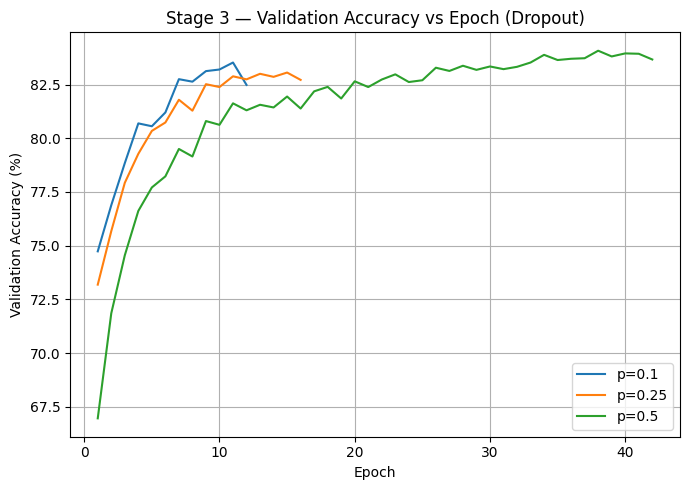

Saved plot: ./results/stage3_dropout_sweep/dropout_val_accuracy.png


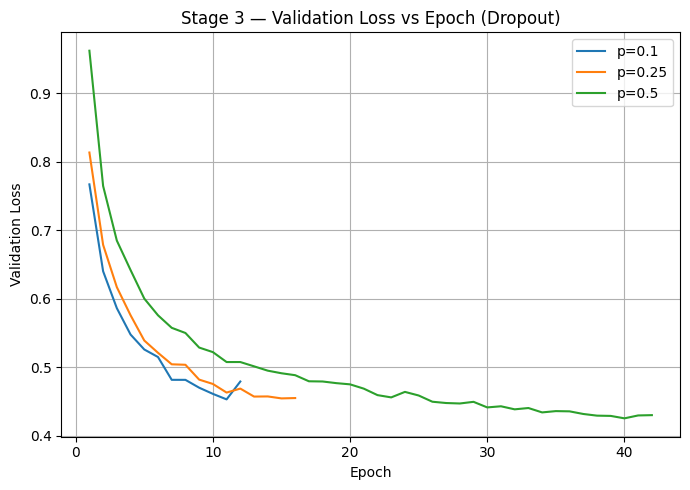

Saved plot: ./results/stage3_dropout_sweep/dropout_val_loss.png


In [ ]:
# Plot 1 — Validation Accuracy
plt.figure(figsize=(7,5))

for dropout_p in dropout_values:
    val_acc = histories[dropout_p]["val_acc"]
    plt.plot(range(1, len(val_acc) + 1), val_acc, label=f"p={dropout_p}")

plt.xlabel("Epoch")
plt.ylabel("Validation Accuracy (%)")
plt.title("Stage 3 — Validation Accuracy vs Epoch (Dropout)")
plt.legend()
plt.grid(True)
plt.tight_layout()

acc_plot_path = os.path.join(sweep_save_dir, "dropout_val_accuracy.png")
plt.savefig(acc_plot_path, dpi=300)
plt.show()
print(f"Saved plot: {acc_plot_path}")

# Plot 2 — Validation Loss 
plt.figure(figsize=(7,5))

for dropout_p in dropout_values:
    val_loss = histories[dropout_p]["val_loss"]
    plt.plot(range(1, len(val_loss) + 1), val_loss, label=f"p={dropout_p}")

plt.xlabel("Epoch")
plt.ylabel("Validation Loss")
plt.title("Stage 3 — Validation Loss vs Epoch (Dropout)")
plt.legend()
plt.grid(True)
plt.tight_layout()

loss_plot_path = os.path.join(sweep_save_dir, "dropout_val_loss.png")
plt.savefig(loss_plot_path, dpi=300)
plt.show()
print(f"Saved plot: {loss_plot_path}")

### Multi-Seed Evaluation for Best Dropout Setting

We evaluate the best-performing dropout probability (p = 0.25)
across three different random seeds: {1, 123, 12345}.

We report:
- Early stopping epoch
- Best validation accuracy
- Final test accuracy

Final performance is reported as:
Mean ± Standard Deviation

In [ ]:
# Stage 3 — Multi-Seed Curves 
best_dropout_p = 0.25
seed_list = [1, 123, 12345]

save_dir = "./results/stage3_dropout_multiseed"
os.makedirs(save_dir, exist_ok=True)

histories = {}
test_accuracies = []
train_times = []
run_ids = []

for seed in seed_list:
    result = run_stage3_dropout(
        seed=seed,
        dropout_p=best_dropout_p,
        init_mode="he",
        lr=0.01,
        momentum=0.9,
        max_epochs=50,
        early_stop_window=5,
        verbose=False,
        save_dir="./results/stage3_dropout",  
        save_model=True
    )

    histories[seed] = result["history"]
    test_accuracies.append(float(result["test_acc"]))
    train_times.append(float(result["train_time_sec"]))
    run_ids.append(result["run_id"])

    print(
        f"Seed {seed} | "
        f"stop@{result['stopped_epoch']} | "
        f"best val {result['best_val_acc']:.2f}% | "
        f"test {result['test_acc']:.2f}% | "
        f"run_id {result['run_id']}"
    )

mean_acc = float(np.mean(test_accuracies))
std_acc  = float(np.std(test_accuracies, ddof=1))
mean_time = float(np.mean(train_times))

print(f"\nDropout p={best_dropout_p} Test Accuracy: {mean_acc:.2f}% ± {std_acc:.2f}%")
print(f"Average Training Time       : {mean_time:.2f} sec")

# Save multiseed summary CSV
csv_path = os.path.join(save_dir, "stage3_dropout_multiseed_summary.csv")
with open(csv_path, "w") as f:
    f.write("seed,dropout_p,test_acc,train_time_sec,run_id\n")
    for s, acc, t, rid in zip(seed_list, test_accuracies, train_times, run_ids):
        f.write(f"{s},{best_dropout_p},{acc:.4f},{t:.4f},{rid}\n")
    f.write(f"\nmean,,{mean_acc:.4f},,\n")
    f.write(f"std,,{std_acc:.4f},,\n")

print(f"Saved CSV:  {csv_path}")

# Save multiseed summary JSON
json_path = os.path.join(save_dir, "stage3_dropout_multiseed_summary.json")
summary_data = {
    "stage": "stage3_dropout_multiseed",
    "dropout_p": best_dropout_p,
    "seeds": seed_list,
    "test_accuracies": test_accuracies,
    "mean_test_accuracy": mean_acc,
    "std_test_accuracy": std_acc,
    "mean_train_time_sec": mean_time,
    "run_ids": run_ids
}
with open(json_path, "w") as f:
    json.dump(summary_data, f, indent=2)

print(f"Saved JSON: {json_path}")



STAGE 3 (DROPOUT) RUN CONFIG
----------------------------------------------------------------------
Run ID            : stage3drop_seed1_p0.25_inithe_lr0.01_m0.9_win5
Seed              : 1
Dropout p         : 0.25
Init              : he
Learning rate     : 0.01
Momentum          : 0.9
Max epochs        : 50
Early-stop window : 5
Seed 1 | stop@40 | best val 85.47% | test 83.99% | run_id stage3drop_seed1_p0.25_inithe_lr0.01_m0.9_win5


STAGE 3 (DROPOUT) RUN CONFIG
----------------------------------------------------------------------
Run ID            : stage3drop_seed123_p0.25_inithe_lr0.01_m0.9_win5
Seed              : 123
Dropout p         : 0.25
Init              : he
Learning rate     : 0.01
Momentum          : 0.9
Max epochs        : 50
Early-stop window : 5
Seed 123 | stop@16 | best val 83.06% | test 82.09% | run_id stage3drop_seed123_p0.25_inithe_lr0.01_m0.9_win5


STAGE 3 (DROPOUT) RUN CONFIG
----------------------------------------------------------------------
Run ID        

## Graph Plotation

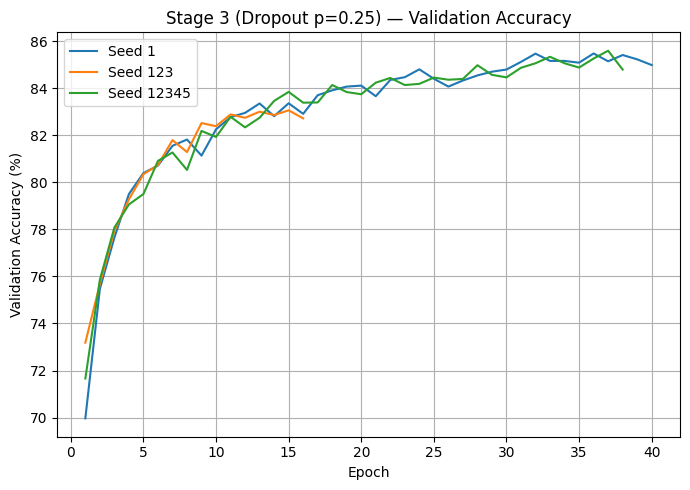

Saved plot: ./results/stage3_dropout_multiseed/stage3_dropout_multiseed_val_accuracy.png


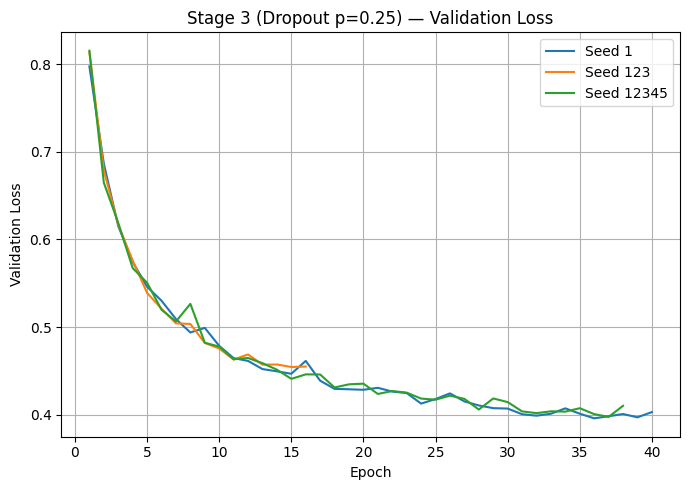

Saved plot: ./results/stage3_dropout_multiseed/stage3_dropout_multiseed_val_loss.png


In [ ]:
# Plot 1 — Validation Accuracy 
plt.figure(figsize=(7,5))
for seed in seed_list:
    val_acc = histories[seed]["val_acc"]
    plt.plot(range(1, len(val_acc)+1), val_acc, label=f"Seed {seed}")

plt.xlabel("Epoch")
plt.ylabel("Validation Accuracy (%)")
plt.title(f"Stage 3 (Dropout p={best_dropout_p}) — Validation Accuracy")
plt.legend()
plt.grid(True)
plt.tight_layout()

acc_plot_path = os.path.join(save_dir, "stage3_dropout_multiseed_val_accuracy.png")
plt.savefig(acc_plot_path, dpi=300)
plt.show()
print(f"Saved plot: {acc_plot_path}")

# Plot 2 — Validation Loss 
plt.figure(figsize=(7,5))
for seed in seed_list:
    val_loss = histories[seed]["val_loss"]
    plt.plot(range(1, len(val_loss)+1), val_loss, label=f"Seed {seed}")

plt.xlabel("Epoch")
plt.ylabel("Validation Loss")
plt.title(f"Stage 3 (Dropout p={best_dropout_p}) — Validation Loss")
plt.legend()
plt.grid(True)
plt.tight_layout()

loss_plot_path = os.path.join(save_dir, "stage3_dropout_multiseed_val_loss.png")
plt.savefig(loss_plot_path, dpi=300)
plt.show()
print(f"Saved plot: {loss_plot_path}")

## L2 Weight Norm Computation

This helper function computes the overall L2 norm of all weight parameters
in the model.

This is used to analyze the effect of L2 regularization (weight decay)
on parameter magnitudes.

Only weight tensors are included (bias terms are excluded).

In [45]:
def compute_l2_weight_norm(model: nn.Module) -> float:
    """
    Compute the global L2 norm of all weight parameters in the model.

    Args:
        model (nn.Module): Trained neural network

    Returns:
        float: L2 norm of all weight tensors
    """

    total_squared_norm = 0.0

    with torch.no_grad():
        for name, param in model.named_parameters():
            if "weight" in name:
                total_squared_norm += torch.sum(param ** 2).item()

    return math.sqrt(total_squared_norm)

## Training Runner with Weight Decay (L2 Regularization)

This function trains the baseline MLP using **L2 regularization** via optimizer weight decay.

Key points:
- Weight decay is applied through the SGD optimizer (`weight_decay=λ`)
- Training procedure remains identical to Stage 2 for fair comparison
- We also track the L2 norm of weights over time to analyze how λ affects weight magnitude
- Early stopping is applied using the assignment validation error rule

In [ ]:
def run_stage3_weight_decay(
    seed: int,
    weight_decay: float,
    init_mode: str,
    lr: float,
    momentum: float,
    max_epochs: int,
    early_stop_window: int,
    verbose: bool,
    save_dir: str,
    save_model: bool
) -> dict:
    """
    Stage 3 — Weight Decay (L2 regularization) using SGD weight_decay.

    Logging:
        - Saves per-epoch metrics to CSV
        - Saves final summary to JSON
        - Optionally saves best model checkpoint

    Returns:
        dict with metrics + history + file paths
    """

    set_seed(seed)
    ensure_dir(save_dir)

    run_id = make_run_id(
        "stage3wd",
        seed,
        lam=weight_decay,
        init=init_mode,
        lr=lr,
        m=momentum,
        win=early_stop_window
    )

    csv_path = os.path.join(save_dir, f"{run_id}_history.csv")
    json_path = os.path.join(save_dir, f"{run_id}_summary.json")
    ckpt_path = os.path.join(save_dir, f"{run_id}_best.pt")

    # Print run config (Stage 2 style)
    print("\n")
    print("STAGE 3 (WEIGHT DECAY) RUN CONFIG")
    print("-" * 70)
    print(f"Run ID            : {run_id}")
    print(f"Seed              : {seed}")
    print(f"Weight decay (λ)  : {weight_decay}")
    print(f"Init              : {init_mode}")
    print(f"Learning rate     : {lr}")
    print(f"Momentum          : {momentum}")
    print(f"Max epochs        : {max_epochs}")
    print(f"Early-stop window : {early_stop_window}")

    model = MLP()
    init_weights(model, init_mode)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(
        model.parameters(),
        lr=lr,
        momentum=momentum,
        weight_decay=weight_decay
    )

    history = {
        "train_loss": [],
        "train_acc": [],
        "val_loss": [],
        "val_acc": [],
        "weight_norm": []
    }

    # CSV header
    with open(csv_path, "w") as f:
        f.write("epoch,train_loss,train_acc,val_loss,val_acc,weight_norm\n")

    val_errors = []
    best_val_acc = -1.0
    best_state = None
    stopped_epoch = max_epochs

    start_time = time.time()

    for epoch in range(1, max_epochs + 1):
        model.train()

        train_loss_sum = 0.0
        train_total = 0
        train_correct = 0

        for inputs, targets in train_loader:
            optimizer.zero_grad()

            logits = model(inputs)
            loss = criterion(logits, targets)  

            loss.backward()
            optimizer.step()

            train_loss_sum += loss.item()
            preds = torch.argmax(logits, dim=1)

            train_total += targets.size(0)
            train_correct += (preds == targets).sum().item()

        train_loss = train_loss_sum / len(train_loader)
        train_acc = 100.0 * train_correct / train_total

        val_loss, val_acc = evaluate_acc_loss(model, val_loader, criterion)

        weight_norm = compute_l2_weight_norm(model)

        history["train_loss"].append(train_loss)
        history["train_acc"].append(train_acc)
        history["val_loss"].append(val_loss)
        history["val_acc"].append(val_acc)
        history["weight_norm"].append(weight_norm)

        # append to CSV
        with open(csv_path, "a") as f:
            f.write(f"{epoch},{train_loss:.6f},{train_acc:.4f},{val_loss:.6f},{val_acc:.4f},{weight_norm:.6f}\n")

        # best model
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_state = {k: v.cpu().clone() for k, v in model.state_dict().items()}
            if save_model:
                torch.save(best_state, ckpt_path)

        # early stopping (same rule)
        val_error = 1.0 - (val_acc / 100.0)
        val_errors.append(val_error)

        if len(val_errors) >= early_stop_window + 1:
            recent = np.array(val_errors[-(early_stop_window + 1):-1])
            if val_error > (recent.mean() + recent.std()):
                stopped_epoch = epoch
                if verbose:
                    print(f"EARLY STOP at epoch {epoch} | Train Acc: {train_acc:.2f}% | Val Acc: {val_acc:.2f}%")
                break

        if verbose:
            print(f"Epoch {epoch}/{max_epochs} | Train Acc: {train_acc:.2f}% | Val Acc: {val_acc:.2f}%")

    train_time_sec = time.time() - start_time

    # restore best model
    if best_state is None:
        best_state = {k: v.cpu().clone() for k, v in model.state_dict().items()}
    model.load_state_dict(best_state)

    # test
    _, test_acc = evaluate_acc_loss(model, test_loader, nn.CrossEntropyLoss())
    final_weight_norm = compute_l2_weight_norm(model)

    summary = {
        "run_id": run_id,
        "stage": "stage3_weight_decay",
        "seed": seed,
        "weight_decay": weight_decay,
        "init_mode": init_mode,
        "lr": lr,
        "momentum": momentum,
        "max_epochs": max_epochs,
        "early_stop_window": early_stop_window,
        "stopped_epoch": stopped_epoch,
        "best_val_acc": best_val_acc,
        "test_acc": float(test_acc),
        "train_time_sec": float(train_time_sec),
        "final_weight_norm": float(final_weight_norm),
        "history_csv": csv_path,
        "summary_json": json_path,
        "best_model_path": ckpt_path if save_model else None,
        "timestamp": datetime.now().isoformat(timespec="seconds")
    }

    with open(json_path, "w") as f:
        json.dump(summary, f, indent=2)

    return {
        "seed": seed,
        "weight_decay": weight_decay,
        "init_mode": init_mode,
        "lr": lr,
        "momentum": momentum,
        "stopped_epoch": stopped_epoch,
        "best_val_acc": best_val_acc,
        "test_acc": test_acc,
        "train_time_sec": train_time_sec,
        "final_weight_norm": final_weight_norm,
        "history": history,
        "run_id": run_id,
        "history_csv": csv_path,
        "summary_json": json_path,
        "best_model_path": ckpt_path if save_model else None
    }

### Weight Decay (L2 Regularization) Exploration

We evaluate different values of λ ∈ {1e-5, 1e-4, 1e-3, 1e-2}.

All other hyperparameters are fixed to isolate the effect of L2 regularization.

For each λ, we report:
- Early stopping epoch
- Best validation accuracy
- Final test accuracy
- Final L2 weight norm

### Multi-Seed Evaluation for Best Weight Decay (λ)

Using the best-performing weight decay value (λ = 1e-3),
we repeat training with three different random seeds: {1, 123, 12345}.

We report:
- Early stopping epoch
- Best validation accuracy
- Final test accuracy
- Final weight norm (to show regularization effect)

Final results are summarized as Mean ± Standard Deviation.

In [ ]:
# Stage 3 — Weight Decay 
weight_decay_values = [1e-5, 1e-4, 1e-3, 1e-2]

save_dir_sweep = "./results/stage3_weight_decay_sweep"
os.makedirs(save_dir_sweep, exist_ok=True)

histories = {}
rows = []  

print("Stage 3 — Weight Decay Experiments\n")

for wd in weight_decay_values:
    result = run_stage3_weight_decay(
        seed=123,
        weight_decay=wd,
        init_mode="he",
        lr=0.01,
        momentum=0.9,
        max_epochs=50,
        early_stop_window=5,
        verbose=False,
        save_dir="./results/stage3_weight_decay",   
        save_model=True
    )

    histories[wd] = result["history"]

    rows.append({
        "weight_decay": wd,
        "stopped_epoch": int(result["stopped_epoch"]),
        "best_val_acc": float(result["best_val_acc"]),
        "test_acc": float(result["test_acc"]),
        "final_weight_norm": float(result["final_weight_norm"]),
        "train_time_sec": float(result["train_time_sec"]),
        "run_id": result["run_id"]
    })

    print(
        f"λ={wd:.0e} | "
        f"stop@{result['stopped_epoch']} | "
        f"best val {result['best_val_acc']:.2f}% | "
        f"test {result['test_acc']:.2f}% | "
        f"weight_norm {result['final_weight_norm']:.4f}"
    )

# Save sweep summary CSV + JSON
csv_path = os.path.join(save_dir_sweep, "stage3_weight_decay_sweep_summary.csv")
with open(csv_path, "w") as f:
    f.write("weight_decay,stopped_epoch,best_val_acc,test_acc,final_weight_norm,train_time_sec,run_id\n")
    for r in rows:
        f.write(
            f"{r['weight_decay']},{r['stopped_epoch']},"
            f"{r['best_val_acc']:.4f},{r['test_acc']:.4f},"
            f"{r['final_weight_norm']:.6f},{r['train_time_sec']:.4f},{r['run_id']}\n"
        )
print(f"\nSaved CSV:  {csv_path}")

json_path = os.path.join(save_dir_sweep, "stage3_weight_decay_sweep_summary.json")
with open(json_path, "w") as f:
    json.dump({"stage": "stage3_weight_decay_sweep", "seed": 123, "results": rows}, f, indent=2)
print(f"Saved JSON: {json_path}")

Stage 3 — Weight Decay Experiments



STAGE 3 (WEIGHT DECAY) RUN CONFIG
----------------------------------------------------------------------
Run ID            : stage3wd_seed123_lam1e-05_inithe_lr0.01_m0.9_win5
Seed              : 123
Weight decay (λ)  : 1e-05
Init              : he
Learning rate     : 0.01
Momentum          : 0.9
Max epochs        : 50
Early-stop window : 5
λ=1e-05 | stop@18 | best val 84.71% | test 83.41% | weight_norm 29.2643


STAGE 3 (WEIGHT DECAY) RUN CONFIG
----------------------------------------------------------------------
Run ID            : stage3wd_seed123_lam0.0001_inithe_lr0.01_m0.9_win5
Seed              : 123
Weight decay (λ)  : 0.0001
Init              : he
Learning rate     : 0.01
Momentum          : 0.9
Max epochs        : 50
Early-stop window : 5
λ=1e-04 | stop@18 | best val 84.74% | test 83.42% | weight_norm 28.9539


STAGE 3 (WEIGHT DECAY) RUN CONFIG
----------------------------------------------------------------------
Run ID            : sta

## Graph Plotation

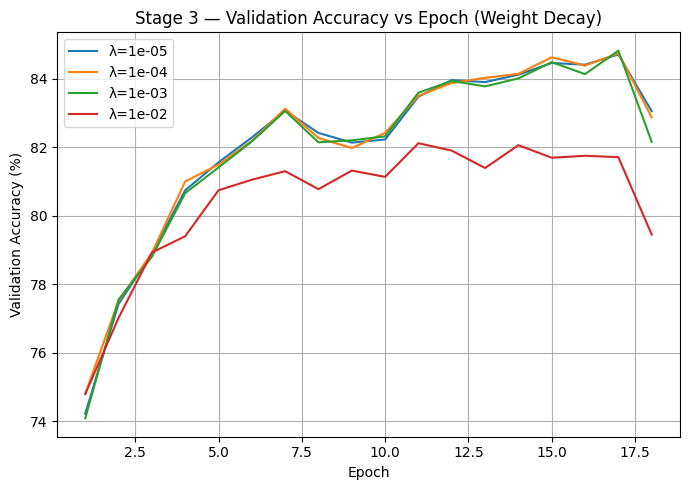

Saved plot: ./results/stage3_weight_decay_sweep/stage3_weight_decay_val_accuracy.png


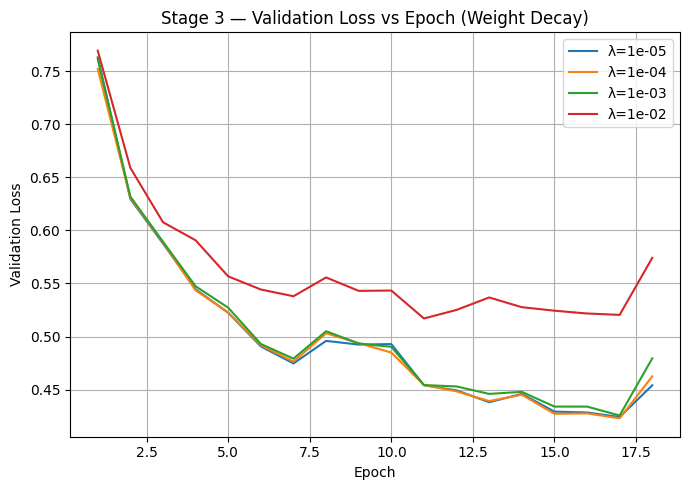

Saved plot: ./results/stage3_weight_decay_sweep/stage3_weight_decay_val_loss.png


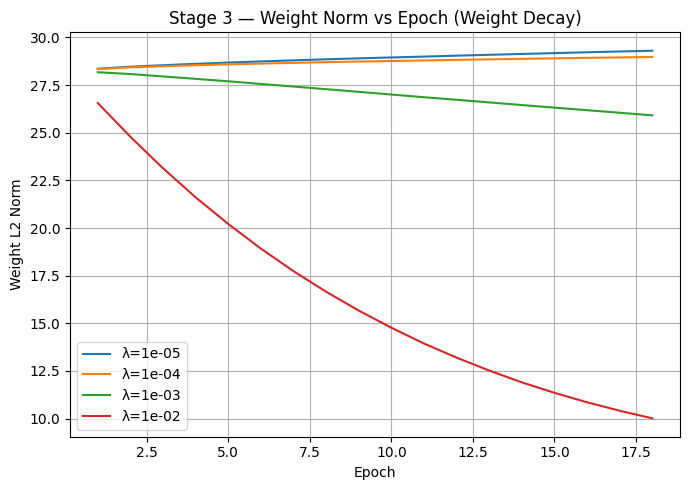

Saved plot: ./results/stage3_weight_decay_sweep/stage3_weight_decay_weight_norm.png


In [49]:

plt.figure(figsize=(7,5))
for wd in weight_decay_values:
    val_acc = histories[wd]["val_acc"]
    plt.plot(range(1, len(val_acc)+1), val_acc, label=f"λ={wd:.0e}")

plt.xlabel("Epoch")
plt.ylabel("Validation Accuracy (%)")
plt.title("Stage 3 — Validation Accuracy vs Epoch (Weight Decay)")
plt.legend()
plt.grid(True)
plt.tight_layout()

acc_plot_path = os.path.join(save_dir_sweep, "stage3_weight_decay_val_accuracy.png")
plt.savefig(acc_plot_path, dpi=300)
plt.show()
print(f"Saved plot: {acc_plot_path}")

# --------------------------------------------------
# Plot 2 — Validation Loss (4 curves)  ✅ like Stage 2
# --------------------------------------------------

plt.figure(figsize=(7,5))
for wd in weight_decay_values:
    val_loss = histories[wd]["val_loss"]
    plt.plot(range(1, len(val_loss)+1), val_loss, label=f"λ={wd:.0e}")

plt.xlabel("Epoch")
plt.ylabel("Validation Loss")
plt.title("Stage 3 — Validation Loss vs Epoch (Weight Decay)")
plt.legend()
plt.grid(True)
plt.tight_layout()
loss_plot_path = os.path.join(save_dir_sweep, "stage3_weight_decay_val_loss.png")
plt.savefig(loss_plot_path, dpi=300)
plt.show()
print(f"Saved plot: {loss_plot_path}")

# --------------------------------------------------
# Plot 3 — Weight Norm (optional but useful)
# --------------------------------------------------

plt.figure(figsize=(7,5))
for wd in weight_decay_values:
    wnorm = histories[wd]["weight_norm"]
    plt.plot(range(1, len(wnorm)+1), wnorm, label=f"λ={wd:.0e}")

plt.xlabel("Epoch")
plt.ylabel("Weight L2 Norm")
plt.title("Stage 3 — Weight Norm vs Epoch (Weight Decay)")
plt.legend()
plt.grid(True)
plt.tight_layout()

wn_plot_path = os.path.join(save_dir_sweep, "stage3_weight_decay_weight_norm.png")
plt.savefig(wn_plot_path, dpi=300)
plt.show()
print(f"Saved plot: {wn_plot_path}")

MULTI seed


In [ ]:
# Stage 3 — Weight Decay 
import os, json
import numpy as np
import matplotlib.pyplot as plt

best_weight_decay = 1e-3
seed_list = [1, 123, 12345]

save_dir_multiseed = "./results/stage3_weight_decay_multiseed"
os.makedirs(save_dir_multiseed, exist_ok=True)

histories = {}
test_accuracies = []
train_times = []
run_ids = []
final_weight_norms = []

print("Stage 3 — Weight Decay Multi-Seed\n")

for seed in seed_list:
    result = run_stage3_weight_decay(
        seed=seed,
        weight_decay=best_weight_decay,
        init_mode="he",
        lr=0.01,
        momentum=0.9,
        max_epochs=50,
        early_stop_window=5,
        verbose=False,
        save_dir="./results/stage3_weight_decay",  
        save_model=True
    )

    histories[seed] = result["history"]
    test_accuracies.append(float(result["test_acc"]))
    train_times.append(float(result["train_time_sec"]))
    run_ids.append(result["run_id"])
    final_weight_norms.append(float(result["final_weight_norm"]))

    print(
        f"Seed {seed} | "
        f"λ={best_weight_decay:.0e} | "
        f"stop@{result['stopped_epoch']} | "
        f"best val {result['best_val_acc']:.2f}% | "
        f"test {result['test_acc']:.2f}% | "
        f"weight_norm {result['final_weight_norm']:.4f} | "
        f"run_id {result['run_id']}"
    )

mean_acc = float(np.mean(test_accuracies))
std_acc = float(np.std(test_accuracies, ddof=1))
mean_time = float(np.mean(train_times))
mean_norm = float(np.mean(final_weight_norms))

print(f"\nWeight Decay λ={best_weight_decay:.0e} Test Accuracy: {mean_acc:.2f}% ± {std_acc:.2f}%")
print(f"Average Training Time: {mean_time:.2f} sec")
print(f"Average Weight Norm : {mean_norm:.4f}")

# Save summary CSV + JSON
csv_path = os.path.join(save_dir_multiseed, "stage3_weight_decay_multiseed_summary.csv")
with open(csv_path, "w") as f:
    f.write("seed,weight_decay,test_acc,train_time_sec,final_weight_norm,run_id\n")
    for s, acc, t, wn, rid in zip(seed_list, test_accuracies, train_times, final_weight_norms, run_ids):
        f.write(f"{s},{best_weight_decay},{acc:.4f},{t:.4f},{wn:.6f},{rid}\n")
    f.write(f"\nmean,,{mean_acc:.4f},{mean_time:.4f},{mean_norm:.6f},\n")
    f.write(f"std,,{std_acc:.4f},,,\n")

print(f"Saved CSV:  {csv_path}")

json_path = os.path.join(save_dir_multiseed, "stage3_weight_decay_multiseed_summary.json")
summary_data = {
    "stage": "stage3_weight_decay_multiseed",
    "weight_decay": best_weight_decay,
    "seeds": seed_list,
    "test_accuracies": test_accuracies,
    "mean_test_accuracy": mean_acc,
    "std_test_accuracy": std_acc,
    "mean_train_time_sec": mean_time,
    "final_weight_norms": final_weight_norms,
    "mean_final_weight_norm": mean_norm,
    "run_ids": run_ids
}
with open(json_path, "w") as f:
    json.dump(summary_data, f, indent=2)

print(f"Saved JSON: {json_path}")



Stage 3 — Weight Decay Multi-Seed



STAGE 3 (WEIGHT DECAY) RUN CONFIG
----------------------------------------------------------------------
Run ID            : stage3wd_seed1_lam0.001_inithe_lr0.01_m0.9_win5
Seed              : 1
Weight decay (λ)  : 0.001
Init              : he
Learning rate     : 0.01
Momentum          : 0.9
Max epochs        : 50
Early-stop window : 5
Seed 1 | λ=1e-03 | stop@15 | best val 84.21% | test 82.63% | weight_norm 26.3337 | run_id stage3wd_seed1_lam0.001_inithe_lr0.01_m0.9_win5


STAGE 3 (WEIGHT DECAY) RUN CONFIG
----------------------------------------------------------------------
Run ID            : stage3wd_seed123_lam0.001_inithe_lr0.01_m0.9_win5
Seed              : 123
Weight decay (λ)  : 0.001
Init              : he
Learning rate     : 0.01
Momentum          : 0.9
Max epochs        : 50
Early-stop window : 5
Seed 123 | λ=1e-03 | stop@18 | best val 84.82% | test 83.28% | weight_norm 26.0507 | run_id stage3wd_seed123_lam0.001_inithe_lr0.01_m0.9_win5



## Graph Plotation

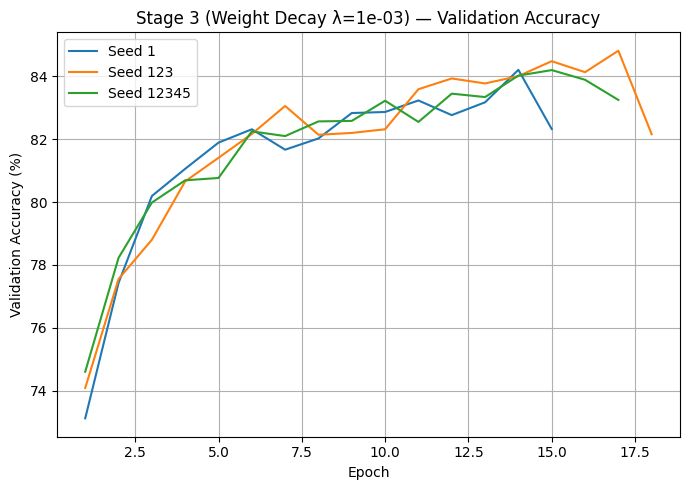

Saved plot: ./results/stage3_weight_decay_multiseed/stage3_weight_decay_multiseed_val_accuracy.png


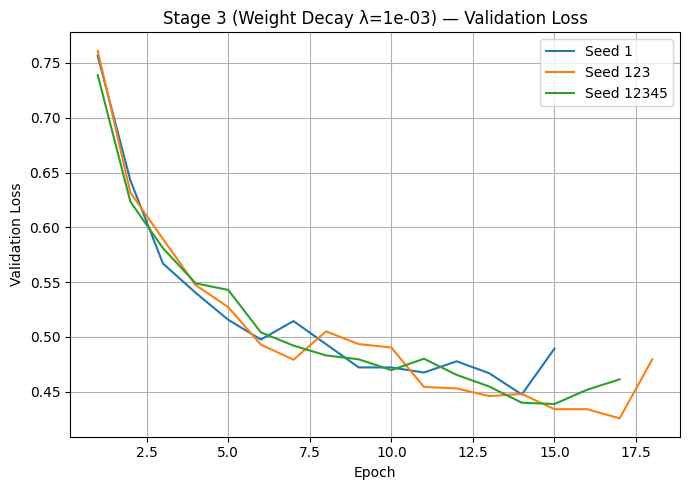

Saved plot: ./results/stage3_weight_decay_multiseed/stage3_weight_decay_multiseed_val_loss.png


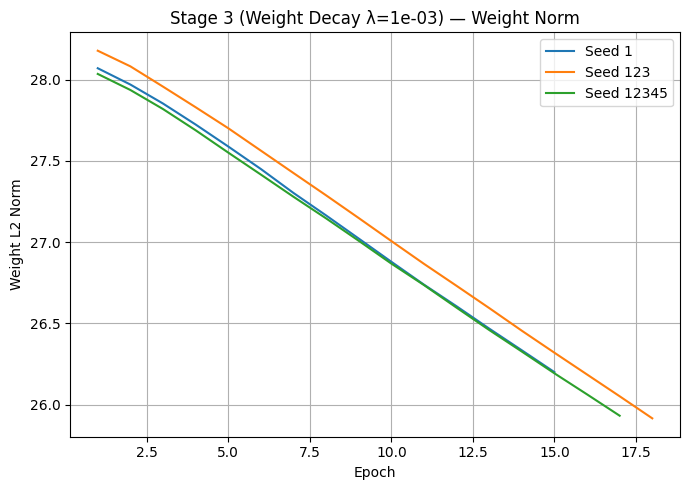

Saved plot: ./results/stage3_weight_decay_multiseed/stage3_weight_decay_multiseed_weight_norm.png


In [ ]:
# Plot 1 — Validation Accuracy
plt.figure(figsize=(7,5))
for seed in seed_list:
    val_acc = histories[seed]["val_acc"]
    plt.plot(range(1, len(val_acc)+1), val_acc, label=f"Seed {seed}")

plt.xlabel("Epoch")
plt.ylabel("Validation Accuracy (%)")
plt.title(f"Stage 3 (Weight Decay λ={best_weight_decay:.0e}) — Validation Accuracy")
plt.legend()
plt.grid(True)
plt.tight_layout()

acc_plot_path = os.path.join(save_dir_multiseed, "stage3_weight_decay_multiseed_val_accuracy.png")
plt.savefig(acc_plot_path, dpi=300)
plt.show()
print(f"Saved plot: {acc_plot_path}")

# Plot 2 — Validation Loss
plt.figure(figsize=(7,5))
for seed in seed_list:
    val_loss = histories[seed]["val_loss"]
    plt.plot(range(1, len(val_loss)+1), val_loss, label=f"Seed {seed}")

plt.xlabel("Epoch")
plt.ylabel("Validation Loss")
plt.title(f"Stage 3 (Weight Decay λ={best_weight_decay:.0e}) — Validation Loss")
plt.legend()
plt.grid(True)
plt.tight_layout()

loss_plot_path = os.path.join(save_dir_multiseed, "stage3_weight_decay_multiseed_val_loss.png")
plt.savefig(loss_plot_path, dpi=300)
plt.show()
print(f"Saved plot: {loss_plot_path}")

# Plot 3 — Weight Norm 
plt.figure(figsize=(7,5))
for seed in seed_list:
    wnorm = histories[seed]["weight_norm"]
    plt.plot(range(1, len(wnorm)+1), wnorm, label=f"Seed {seed}")

plt.xlabel("Epoch")
plt.ylabel("Weight L2 Norm")
plt.title(f"Stage 3 (Weight Decay λ={best_weight_decay:.0e}) — Weight Norm")
plt.legend()
plt.grid(True)
plt.tight_layout()

wn_plot_path = os.path.join(save_dir_multiseed, "stage3_weight_decay_multiseed_weight_norm.png")
plt.savefig(wn_plot_path, dpi=300)
plt.show()
print(f"Saved plot: {wn_plot_path}")

---

# STAGE 4: Semi-Supervised Learning 

## Overview
This stage leverages unlabeled data using **Consistency Regularization with Data Augmentation**.

### Method: Consistency Regularization

**Motivation**: If the model is confident in its predictions, small perturbations (augmentations) should not significantly change those predictions.

**Training Objective**:
$$L = -\sum_{i \in \text{labeled}} \log p_\theta(y_i|x_i) + \lambda \sum_{j \in \text{unlabeled}} \|p_\theta(y|x_j) - p_\theta(y|x_j')\|^2$$

Where:
- First term: **Supervised loss** on labeled data
- Second term: **Consistency loss** - model should output similar distributions for original and augmented unlabeled images
- x'_j: Augmented version of x_j (from Stage 1)
- p_θ(y|x_j): Fixed target (stop gradients) to avoid collapse

**Warm-up Schedule**:
- λ starts at 0 and gradually increases over training
- Allows model to first learn from labeled data
- Gradually incorporates consistency constraint

### Key Implementation Details:
1. Use augmentation from Stage 1 (flip + rotation)
2. Compute predictions on both clean and augmented versions
3. Detach first prediction to prevent gradient flow through target
4. Use warm-up to avoid training instability

## Semi-Supervised Learning (Imports)

Stage 4 introduces semi-supervised training utilities, including:
- dataset wrappers (`TensorDataset`, `ConcatDataset`)
- custom dataset types (`Dataset`)
- optimizer and training utilities
- timing for performance reporting

In [58]:
import os
import json
import time
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

from datetime import datetime
from torch.utils.data import DataLoader, Subset

## Unlabeled Dataset Preparation and Unlabeled Data Loaders


For consistency-based semi-supervised learning, we need:

1. Clean unlabeled inputs (x)
2. Augmented versions of the same unlabeled inputs (x′)

Both datasets use the same indices so that each clean image
corresponds exactly to its augmented version.

Clean data : used as fixed prediction target  
Augmented data : used for consistency training

We create data loaders for clean and augmented versions of the same unlabeled samples.

Important:
- Both loaders must preserve the same ordering.
- Therefore, shuffle is disabled to ensure correct pairing.
- drop_last=True ensures batch sizes match exactly.

In [ ]:
# Unlabeled dataset preparation for consistency training

unlabeled_clean_dataset = Subset(train_minmax, unlabeled_indices)
unlabeled_augmented_dataset = Subset(train_augmented, unlabeled_indices)

print(f"Unlabeled clean samples     : {len(unlabeled_clean_dataset)}")
print(f"Unlabeled augmented samples : {len(unlabeled_augmented_dataset)}")

# Labeled loader
labeled_loader = DataLoader(labeled_augmented, batch_size=128, shuffle=True)

batch_size = 128

unlabeled_clean_loader = DataLoader(
    unlabeled_clean_dataset,
    batch_size=batch_size,
    shuffle=False,
    drop_last=True
)

unlabeled_aug_loader = DataLoader(
    unlabeled_augmented_dataset,
    batch_size=batch_size,
    shuffle=False,
    drop_last=True
)

print(f"Labeled batches        : {len(labeled_loader)}")
print(f"Unlabeled clean batches: {len(unlabeled_clean_loader)}")
print(f"Unlabeled aug batches  : {len(unlabeled_aug_loader)}")

Unlabeled clean samples     : 38400
Unlabeled augmented samples : 38400
Labeled batches        : 75
Unlabeled clean batches: 300
Unlabeled aug batches  : 300


## Semi-Supervised Learning (Method C: Consistency Regularization)

We implement **Consistency Regularization** using both labeled and unlabeled data.

Training objective:
- **Supervised loss** on labeled data (cross-entropy)
- **Consistency loss** on unlabeled data:
  we encourage the model to produce similar predictions for a clean image `x`
  and its augmented version `x′`.

Key implementation details:
- A warm-up schedule is used for λ (starts at 0 and increases to λ_max).
- The clean prediction `p(y|x)` is treated as a **fixed target** using `.detach()`.
- Early stopping is applied using the assignment validation error criterion.

In [59]:
def lambda_warmup(epoch: int, warmup_epochs: int = 10, lambda_max: float = 1.0) -> float:
    if epoch <= 0:
        return 0.0
    if epoch >= warmup_epochs:
        return lambda_max
    return lambda_max * (epoch / warmup_epochs)

## Warm-up Schedule for Consistency Regularization

The consistency regularization loss uses a **warm-up schedule** to gradually introduce the unlabeled data constraint.


### Training Dynamics

- **Epochs 1–10** (default): λ increases from 0 → 1.0
    - Model focuses mainly on supervised loss
    - Consistency loss gradually becomes active
    
- **Epochs 11+**: λ = 1.0 (constant)
    - Both supervised and consistency losses fully active
    - Model balances labeled and unlabeled learning

This gradual approach improves convergence and final performance compared to applying full consistency weight from epoch 1.

In [63]:
def run_stage4_consistency_core(
    seed: int,
    lr: float,
    momentum: float,
    max_epochs: int,
    early_stop_window: int,
    lambda_max: float,
    warmup_epochs: int,
    verbose: bool,
    save_dir: str,
    save_model: bool
) -> dict:
    """
    Stage 4 CORE — Consistency Regularization (Method C only).

    Uses:
      - supervised loss on labeled_loader
      - consistency loss between unlabeled_clean_loader and unlabeled_aug_loader
      - stop-grad target on p_clean
      - lambda warm-up schedule

    Logging:
        - Saves per-epoch metrics to CSV
        - Saves final summary to JSON
        - Optionally saves best model checkpoint

    Returns:
        dict with metrics + history + file paths
    """

    set_seed(seed)
    ensure_dir(save_dir)

    run_id = make_run_id(
        "stage4core",
        seed,
        lr=lr,
        m=momentum,
        lmax=lambda_max,
        warm=warmup_epochs,
        win=early_stop_window
    )

    csv_path = os.path.join(save_dir, f"{run_id}_history.csv")
    json_path = os.path.join(save_dir, f"{run_id}_summary.json")
    ckpt_path = os.path.join(save_dir, f"{run_id}_best.pt")

    # Print run config (Stage 2 style)
    print("\n")
    print("STAGE 4 (CORE: CONSISTENCY ONLY) RUN CONFIG")
    print("-" * 70)
    print(f"Run ID            : {run_id}")
    print(f"Seed              : {seed}")
    print(f"Learning rate     : {lr}")
    print(f"Momentum          : {momentum}")
    print(f"Lambda max        : {lambda_max}")
    print(f"Warmup epochs     : {warmup_epochs}")
    print(f"Max epochs        : {max_epochs}")
    print(f"Early-stop window : {early_stop_window}")

    # Model: NO dropout for core method C
    model = MLP()
    init_weights(model, "he")

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum)  # NO weight decay

    history = {
        "train_loss": [],
        "train_sup_loss": [],
        "train_cons_loss": [],
        "val_loss": [],
        "val_acc": [],
        "lambda": []
    }

    # CSV header
    with open(csv_path, "w") as f:
        f.write("epoch,lambda,train_loss,train_sup_loss,train_cons_loss,val_loss,val_acc\n")

    val_errors = []
    best_val_acc = -1.0
    best_state = None
    stopped_epoch = max_epochs

    start_time = time.time()

    for epoch in range(1, max_epochs + 1):
        model.train()
        lam = lambda_warmup(epoch, warmup_epochs=warmup_epochs, lambda_max=lambda_max)

        total_loss_sum = 0.0
        sup_loss_sum = 0.0
        cons_loss_sum = 0.0
        steps = 0

        for (x_l, y_l), (x_uc, _), (x_ua, _) in zip(
            labeled_loader,
            unlabeled_clean_loader,
            unlabeled_aug_loader
        ):
            optimizer.zero_grad()

            # ----- supervised loss -----
            logits_l = model(x_l)
            loss_sup = criterion(logits_l, y_l)

            # ----- consistency loss (stop-grad target) -----
            logits_clean = model(x_uc)
            p_clean = torch.softmax(logits_clean, dim=1).detach()

            logits_aug = model(x_ua)
            p_aug = torch.softmax(logits_aug, dim=1)

            loss_cons = torch.mean((p_aug - p_clean) ** 2)

            loss = loss_sup + lam * loss_cons
            loss.backward()
            optimizer.step()

            total_loss_sum += loss.item()
            sup_loss_sum += loss_sup.item()
            cons_loss_sum += loss_cons.item()
            steps += 1

        train_loss = total_loss_sum / max(1, steps)
        train_sup_loss = sup_loss_sum / max(1, steps)
        train_cons_loss = cons_loss_sum / max(1, steps)

        # Validation
        val_loss, val_acc = evaluate_acc_loss(model, val_loader, criterion)

        history["train_loss"].append(train_loss)
        history["train_sup_loss"].append(train_sup_loss)
        history["train_cons_loss"].append(train_cons_loss)
        history["val_loss"].append(val_loss)
        history["val_acc"].append(val_acc)
        history["lambda"].append(lam)

        # append to CSV
        with open(csv_path, "a") as f:
            f.write(
                f"{epoch},{lam:.6f},{train_loss:.6f},{train_sup_loss:.6f},"
                f"{train_cons_loss:.6f},{val_loss:.6f},{val_acc:.4f}\n"
            )

        # best model
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_state = {k: v.detach().cpu().clone() for k, v in model.state_dict().items()}
            if save_model:
                torch.save(best_state, ckpt_path)

        # early stopping (same rule)
        val_error = 1.0 - (val_acc / 100.0)
        val_errors.append(val_error)

        if len(val_errors) >= early_stop_window + 1:
            recent = np.array(val_errors[-(early_stop_window + 1):-1])
            if val_error > (recent.mean() + recent.std()):
                stopped_epoch = epoch
                if verbose:
                    print(f"EARLY STOP at epoch {epoch} | λ={lam:.3f} | Val Acc: {val_acc:.2f}%")
                break

        if verbose:
            print(f"Epoch {epoch}/{max_epochs} | λ={lam:.3f} | Val Acc: {val_acc:.2f}%")

    train_time_sec = time.time() - start_time

    # restore best model (safe)
    if best_state is None:
        best_state = {k: v.detach().cpu().clone() for k, v in model.state_dict().items()}
    model.load_state_dict(best_state)

    # test
    _, test_acc = evaluate_acc_loss(model, test_loader, nn.CrossEntropyLoss())

    summary = {
        "run_id": run_id,
        "stage": "stage4_consistency_core",
        "seed": seed,
        "lr": lr,
        "momentum": momentum,
        "lambda_max": lambda_max,
        "warmup_epochs": warmup_epochs,
        "max_epochs": max_epochs,
        "early_stop_window": early_stop_window,
        "stopped_epoch": stopped_epoch,
        "best_val_acc": best_val_acc,
        "test_acc": float(test_acc),
        "train_time_sec": float(train_time_sec),
        "history_csv": csv_path,
        "summary_json": json_path,
        "best_model_path": ckpt_path if save_model else None,
        "timestamp": datetime.now().isoformat(timespec="seconds")
    }

    with open(json_path, "w") as f:
        json.dump(summary, f, indent=2)

    return {
        "seed": seed,
        "lr": lr,
        "momentum": momentum,
        "lambda_max": lambda_max,
        "warmup_epochs": warmup_epochs,
        "stopped_epoch": stopped_epoch,
        "best_val_acc": best_val_acc,
        "test_acc": test_acc,
        "train_time_sec": train_time_sec,
        "history": history,
        "run_id": run_id,
        "history_csv": csv_path,
        "summary_json": json_path,
        "best_model_path": ckpt_path if save_model else None}

In [64]:
def run_stage4_consistency_fullpipline(
    seed=123,
    dropout_p=0.25,
    weight_decay=1e-3,
    lr=0.01,
    momentum=0.9,
    max_epochs=50,
    early_stop_window=5,
    lambda_max=1.0,
    warmup_epochs=10,
    verbose=True,
    save_dir="./results/stage4_fullpipline",
    save_model=True
):
    set_seed(seed)
    os.makedirs(save_dir, exist_ok=True)

    model = MLPDropout(dropout_p=dropout_p)
    init_weights(model, "he")

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(
        model.parameters(),
        lr=lr,
        momentum=momentum,
        weight_decay=weight_decay
    )

    history = {"val_acc": [], "val_loss": [], "lambda": []}

    best_val_acc = -1
    best_state = None
    val_errors = []

    start_time = time.time()

    for epoch in range(1, max_epochs + 1):
        lam = lambda_warmup(epoch, warmup_epochs, lambda_max)
        model.train()

        for (x_l, y_l), (x_uc, _), (x_ua, _) in zip(
            labeled_loader,
            unlabeled_clean_loader,
            unlabeled_aug_loader
        ):
            optimizer.zero_grad()

            loss_sup = criterion(model(x_l), y_l)

            # Stable target: disable dropout
            model.eval()
            with torch.no_grad():
                p_clean = torch.softmax(model(x_uc), dim=1)
            model.train()

            p_aug = torch.softmax(model(x_ua), dim=1)
            loss_cons = torch.mean((p_aug - p_clean) ** 2)

            loss = loss_sup + lam * loss_cons
            loss.backward()
            optimizer.step()

        val_loss, val_acc = evaluate_acc_loss(model, val_loader, criterion)

        history["val_acc"].append(val_acc)
        history["val_loss"].append(val_loss)
        history["lambda"].append(lam)

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_state = {k: v.cpu().clone() for k, v in model.state_dict().items()}

        val_error = 1 - val_acc / 100
        val_errors.append(val_error)

        if len(val_errors) > early_stop_window:
            recent = np.array(val_errors[-early_stop_window:])
            if val_error > recent.mean() + recent.std():
                break

        if verbose:
            print(f"Epoch {epoch} | λ={lam:.3f} | Val Acc: {val_acc:.2f}%")

    train_time = time.time() - start_time

    model.load_state_dict(best_state)
    _, test_acc = evaluate_acc_loss(model, test_loader, criterion)

    return {
        "test_acc": test_acc,
        "best_val_acc": best_val_acc,
        "train_time_sec": train_time,
        "history": history
    }

## Multi-Seed Evaluation (Consistency Regularization)

To assess robustness, we run the Stage 4 consistency method across three random seeds:
{1, 123, 12345}.

We report:
- Early stopping epoch
- Best validation accuracy
- Final test accuracy

Final performance is summarized as Mean ± Standard Deviation.



STAGE 4 (CORE: CONSISTENCY ONLY) RUN CONFIG
----------------------------------------------------------------------
Run ID            : stage4core_seed1_lr0.01_m0.9_lmax1_warm10_win5
Seed              : 1
Learning rate     : 0.01
Momentum          : 0.9
Lambda max        : 1.0
Warmup epochs     : 10
Max epochs        : 50
Early-stop window : 5
Seed 1 | stop@18 | best val 84.62% | test 83.12% | run_id stage4core_seed1_lr0.01_m0.9_lmax1_warm10_win5


STAGE 4 (CORE: CONSISTENCY ONLY) RUN CONFIG
----------------------------------------------------------------------
Run ID            : stage4core_seed123_lr0.01_m0.9_lmax1_warm10_win5
Seed              : 123
Learning rate     : 0.01
Momentum          : 0.9
Lambda max        : 1.0
Warmup epochs     : 10
Max epochs        : 50
Early-stop window : 5
Seed 123 | stop@11 | best val 83.19% | test 82.12% | run_id stage4core_seed123_lr0.01_m0.9_lmax1_warm10_win5


STAGE 4 (CORE: CONSISTENCY ONLY) RUN CONFIG
------------------------------------------

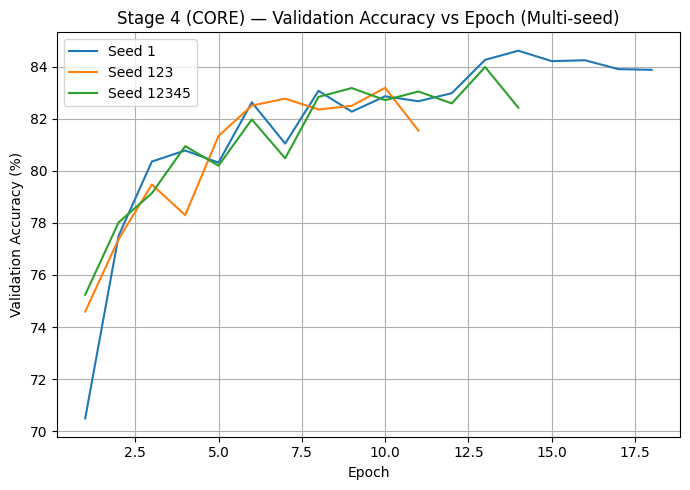

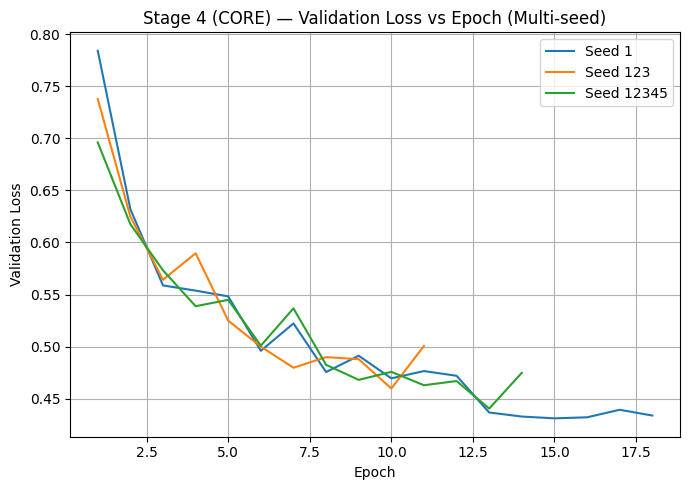

Saved CSV: ./results/stage4_core_multiseed/stage4_core_multiseed_summary.csv
Saved JSON: ./results/stage4_core_multiseed/stage4_core_multiseed_summary.json


In [ ]:

save_dir = "./results/stage4_core_multiseed"
os.makedirs(save_dir, exist_ok=True)

seed_list = [1, 123, 12345]
histories = {}
test_accuracies = []
train_times = []
run_ids = []

for seed in seed_list:
    result = run_stage4_consistency_core(
        seed=seed,
        lr=0.01,
        momentum=0.9,
        max_epochs=50,
        early_stop_window=5,
        lambda_max=1.0,
        warmup_epochs=10,
        verbose=False,
        save_dir="./results/stage4_core",
        save_model=True
    )

    histories[seed] = result["history"]
    test_accuracies.append(result["test_acc"])
    train_times.append(result["train_time_sec"])
    run_ids.append(result["run_id"])

    print(
        f"Seed {seed} | "
        f"stop@{result['stopped_epoch']} | "
        f"best val {result['best_val_acc']:.2f}% | "
        f"test {result['test_acc']:.2f}% | "
        f"run_id {result['run_id']}"
    )

mean_acc = float(np.mean(test_accuracies))
std_acc  = float(np.std(test_accuracies, ddof=1))
mean_time = float(np.mean(train_times))

print(f"\nStage 4 (CORE) Test Accuracy: {mean_acc:.2f}% ± {std_acc:.2f}%")
print(f"Average Training Time       : {mean_time:.2f} sec")


# Save summary 
csv_path = os.path.join(save_dir, "stage4_core_multiseed_summary.csv")
with open(csv_path, "w") as f:
    f.write("seed,test_acc,train_time_sec,run_id\n")
    for s, acc, t, rid in zip(seed_list, test_accuracies, train_times, run_ids):
        f.write(f"{s},{acc:.4f},{t:.4f},{rid}\n")
    f.write(f"\nmean,{mean_acc:.4f},,\n")
    f.write(f"std,{std_acc:.4f},,\n")

print(f"Saved CSV: {csv_path}")

json_path = os.path.join(save_dir, "stage4_core_multiseed_summary.json")
summary_data = {
    "stage": "stage4_core",
    "seeds": seed_list,
    "test_accuracies": test_accuracies,
    "mean_test_accuracy": mean_acc,
    "std_test_accuracy": std_acc,
    "mean_train_time_sec": mean_time,
    "run_ids": run_ids
}
with open(json_path, "w") as f:
    json.dump(summary_data, f, indent=2)

print(f"Saved JSON: {json_path}")

## Graph Plotation

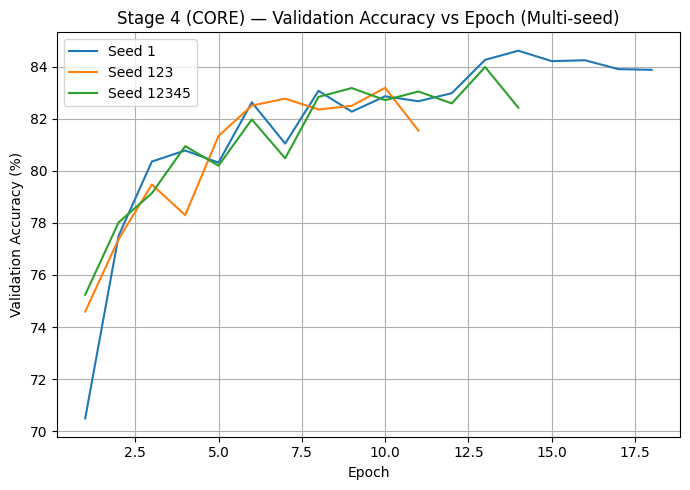

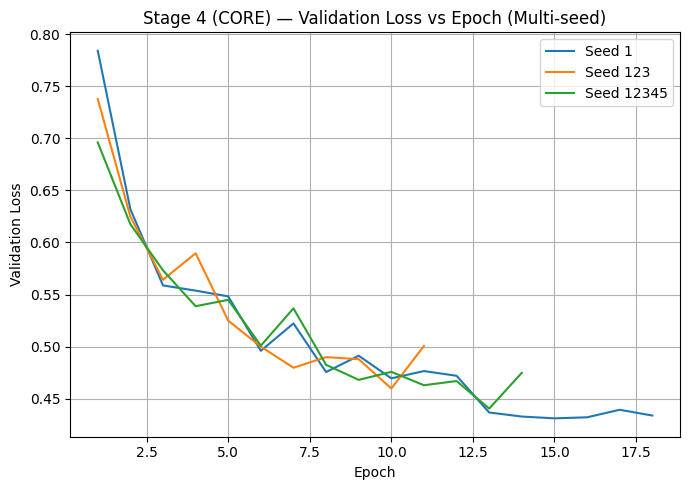

In [ ]:
# Plot 1 — Validation Accuracy curves (per seed)
plt.figure(figsize=(7,5))

for seed in seed_list:
    val_acc = histories[seed]["val_acc"]
    plt.plot(range(1, len(val_acc) + 1), val_acc, label=f"Seed {seed}")

plt.xlabel("Epoch")
plt.ylabel("Validation Accuracy (%)")
plt.title("Stage 4 (CORE) — Validation Accuracy vs Epoch (Multi-seed)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot 2 — Validation Loss curves (per seed)
plt.figure(figsize=(7,5))

for seed in seed_list:
    val_loss = histories[seed]["val_loss"]
    plt.plot(range(1, len(val_loss) + 1), val_loss, label=f"Seed {seed}")

plt.xlabel("Epoch")
plt.ylabel("Validation Loss")
plt.title("Stage 4 (CORE) — Validation Loss vs Epoch (Multi-seed)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
def run_stage4_consistency_full(
    seed: int,
    dropout_p: float,
    weight_decay: float,
    lr: float,
    momentum: float,
    max_epochs: int,
    early_stop_window: int,
    lambda_max: float,
    warmup_epochs: int,
    verbose: bool,
    save_dir: str,
    save_model: bool
) -> dict:
    """
    Stage 4 FULL — Consistency Regularization + Dropout + Weight Decay.

    Logging:
        - Saves per-epoch metrics to CSV
        - Saves final summary to JSON
        - Optionally saves best model checkpoint

    Returns:
        dict with metrics + history + file paths
    """

    set_seed(seed)
    ensure_dir(save_dir)

    run_id = make_run_id(
        "stage4full",
        seed,
        p=dropout_p,
        wd=weight_decay,
        lr=lr,
        m=momentum,
        lmax=lambda_max,
        warm=warmup_epochs,
        win=early_stop_window
    )

    csv_path = os.path.join(save_dir, f"{run_id}_history.csv")
    json_path = os.path.join(save_dir, f"{run_id}_summary.json")
    ckpt_path = os.path.join(save_dir, f"{run_id}_best.pt")

    # Print run config (Stage 2 style)
    print("\n")
    print("STAGE 4 (FULL: CONSISTENCY + DROPOUT + WEIGHT DECAY) RUN CONFIG")
    print("-" * 70)
    print(f"Run ID            : {run_id}")
    print(f"Seed              : {seed}")
    print(f"Dropout p         : {dropout_p}")
    print(f"Weight decay (λ)  : {weight_decay}")
    print(f"Learning rate     : {lr}")
    print(f"Momentum          : {momentum}")
    print(f"Lambda max        : {lambda_max}")
    print(f"Warmup epochs     : {warmup_epochs}")
    print(f"Max epochs        : {max_epochs}")
    print(f"Early-stop window : {early_stop_window}")

    model = MLPDropout(dropout_p=dropout_p)
    init_weights(model, "he")

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(
        model.parameters(),
        lr=lr,
        momentum=momentum,
        weight_decay=weight_decay
    )

    history = {
        "train_loss": [],
        "train_sup_loss": [],
        "train_cons_loss": [],
        "val_loss": [],
        "val_acc": [],
        "lambda": []
    }

    # CSV header
    with open(csv_path, "w") as f:
        f.write("epoch,lambda,train_loss,train_sup_loss,train_cons_loss,val_loss,val_acc\n")

    val_errors = []
    best_val_acc = -1.0
    best_state = None
    stopped_epoch = max_epochs

    start_time = time.time()

    for epoch in range(1, max_epochs + 1):
        lam = lambda_warmup(epoch, warmup_epochs=warmup_epochs, lambda_max=lambda_max)
        model.train()

        total_loss_sum = 0.0
        sup_loss_sum = 0.0
        cons_loss_sum = 0.0
        steps = 0

        for (x_l, y_l), (x_uc, _), (x_ua, _) in zip(
            labeled_loader,
            unlabeled_clean_loader,
            unlabeled_aug_loader
        ):
            optimizer.zero_grad()

            # supervised
            logits_l = model(x_l)
            loss_sup = criterion(logits_l, y_l)

            # consistency target with dropout OFF for stability
            model.eval()
            with torch.no_grad():
                logits_clean = model(x_uc)
                p_clean = torch.softmax(logits_clean, dim=1)
            model.train()

            logits_aug = model(x_ua)
            p_aug = torch.softmax(logits_aug, dim=1)

            loss_cons = torch.mean((p_aug - p_clean) ** 2)

            loss = loss_sup + lam * loss_cons
            loss.backward()
            optimizer.step()

            total_loss_sum += loss.item()
            sup_loss_sum += loss_sup.item()
            cons_loss_sum += loss_cons.item()
            steps += 1

        train_loss = total_loss_sum / max(1, steps)
        train_sup_loss = sup_loss_sum / max(1, steps)
        train_cons_loss = cons_loss_sum / max(1, steps)

        # Validation
        val_loss, val_acc = evaluate_acc_loss(model, val_loader, criterion)

        history["train_loss"].append(train_loss)
        history["train_sup_loss"].append(train_sup_loss)
        history["train_cons_loss"].append(train_cons_loss)
        history["val_loss"].append(val_loss)
        history["val_acc"].append(val_acc)
        history["lambda"].append(lam)

        # append to CSV
        with open(csv_path, "a") as f:
            f.write(
                f"{epoch},{lam:.6f},{train_loss:.6f},{train_sup_loss:.6f},"
                f"{train_cons_loss:.6f},{val_loss:.6f},{val_acc:.4f}\n"
            )

        # best model
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_state = {k: v.detach().cpu().clone() for k, v in model.state_dict().items()}
            if save_model:
                torch.save(best_state, ckpt_path)

        # early stopping
        val_error = 1.0 - (val_acc / 100.0)
        val_errors.append(val_error)

        if len(val_errors) >= early_stop_window + 1:
            recent = np.array(val_errors[-(early_stop_window + 1):-1])
            if val_error > (recent.mean() + recent.std()):
                stopped_epoch = epoch
                if verbose:
                    print(f"EARLY STOP at epoch {epoch} | λ={lam:.3f} | Val Acc: {val_acc:.2f}%")
                break

        if verbose:
            print(f"Epoch {epoch}/{max_epochs} | λ={lam:.3f} | Val Acc: {val_acc:.2f}%")

    train_time_sec = time.time() - start_time

    # restore best model (safe)
    if best_state is None:
        best_state = {k: v.detach().cpu().clone() for k, v in model.state_dict().items()}
    model.load_state_dict(best_state)

    # test
    _, test_acc = evaluate_acc_loss(model, test_loader, nn.CrossEntropyLoss())

    summary = {
        "run_id": run_id,
        "stage": "stage4_consistency_full",
        "seed": seed,
        "dropout_p": dropout_p,
        "weight_decay": weight_decay,
        "lr": lr,
        "momentum": momentum,
        "lambda_max": lambda_max,
        "warmup_epochs": warmup_epochs,
        "max_epochs": max_epochs,
        "early_stop_window": early_stop_window,
        "stopped_epoch": stopped_epoch,
        "best_val_acc": best_val_acc,
        "test_acc": float(test_acc),
        "train_time_sec": float(train_time_sec),
        "history_csv": csv_path,
        "summary_json": json_path,
        "best_model_path": ckpt_path if save_model else None,
        "timestamp": datetime.now().isoformat(timespec="seconds")
    }

    with open(json_path, "w") as f:
        json.dump(summary, f, indent=2)

    return {
        "seed": seed,
        "dropout_p": dropout_p,
        "weight_decay": weight_decay,
        "lr": lr,
        "momentum": momentum,
        "lambda_max": lambda_max,
        "warmup_epochs": warmup_epochs,
        "stopped_epoch": stopped_epoch,
        "best_val_acc": best_val_acc,
        "test_acc": test_acc,
        "train_time_sec": train_time_sec,
        "history": history,
        "run_id": run_id,
        "history_csv": csv_path,
        "summary_json": json_path,
        "best_model_path": ckpt_path if save_model else None
    }

## Runner

In [81]:
# Stage 4 (FULL) — Multi-seed evaluation + curves
# (Consistency + Dropout + Weight Decay)

save_dir = "./results/stage4_full_multiseed"
os.makedirs(save_dir, exist_ok=True)

seed_list = [1, 123, 12345]
histories = {}
test_accuracies = []
train_times = []
run_ids = []

best_dropout_p = 0.25
best_weight_decay = 1e-3

for seed in seed_list:
    result = run_stage4_consistency_full(
        seed=seed,
        dropout_p=best_dropout_p,
        weight_decay=best_weight_decay,
        lr=0.01,
        momentum=0.9,
        max_epochs=50,
        early_stop_window=5,
        lambda_max=1.0,
        warmup_epochs=10,
        verbose=False,
        save_dir="./results/stage4_full",
        save_model=True
    )

    histories[seed] = result["history"]
    test_accuracies.append(result["test_acc"])
    train_times.append(result["train_time_sec"])
    run_ids.append(result["run_id"])

    print(
        f"Seed {seed} | "
        f"p={best_dropout_p} | "
        f"wd={best_weight_decay:.0e} | "
        f"stop@{result['stopped_epoch']} | "
        f"best val {result['best_val_acc']:.2f}% | "
        f"test {result['test_acc']:.2f}% | "
        f"run_id {result['run_id']}"
    )

mean_acc = float(np.mean(test_accuracies))
std_acc  = float(np.std(test_accuracies, ddof=1))
mean_time = float(np.mean(train_times))

print(f"\nStage 4 (FULL) Test Accuracy: {mean_acc:.2f}% ± {std_acc:.2f}%")
print(f"Average Training Time       : {mean_time:.2f} sec")



# Save summary 
csv_path = os.path.join(save_dir, "stage4_full_multiseed_summary.csv")
with open(csv_path, "w") as f:
    f.write("seed,test_acc,train_time_sec,run_id\n")
    for s, acc, t, rid in zip(seed_list, test_accuracies, train_times, run_ids):
        f.write(f"{s},{acc:.4f},{t:.4f},{rid}\n")
    f.write(f"\nmean,{mean_acc:.4f},,\n")
    f.write(f"std,{std_acc:.4f},,\n")

print(f"Saved CSV: {csv_path}")

json_path = os.path.join(save_dir, "stage4_full_multiseed_summary.json")
summary_data = {
    "stage": "stage4_full_consistency_dropout_weightdecay",
    "seeds": seed_list,
    "dropout_p": best_dropout_p,
    "weight_decay": best_weight_decay,
    "test_accuracies": test_accuracies,
    "mean_test_accuracy": mean_acc,
    "std_test_accuracy": std_acc,
    "mean_train_time_sec": mean_time,
    "run_ids": run_ids
}
with open(json_path, "w") as f:
    json.dump(summary_data, f, indent=2)

print(f"Saved JSON: {json_path}")



STAGE 4 (FULL: CONSISTENCY + DROPOUT + WEIGHT DECAY) RUN CONFIG
----------------------------------------------------------------------
Run ID            : stage4full_seed1_p0.25_wd0.001_lr0.01_m0.9_lmax1_warm10_win5
Seed              : 1
Dropout p         : 0.25
Weight decay (λ)  : 0.001
Learning rate     : 0.01
Momentum          : 0.9
Lambda max        : 1.0
Warmup epochs     : 10
Max epochs        : 50
Early-stop window : 5
Seed 1 | p=0.25 | wd=1e-03 | stop@24 | best val 84.23% | test 83.13% | run_id stage4full_seed1_p0.25_wd0.001_lr0.01_m0.9_lmax1_warm10_win5


STAGE 4 (FULL: CONSISTENCY + DROPOUT + WEIGHT DECAY) RUN CONFIG
----------------------------------------------------------------------
Run ID            : stage4full_seed123_p0.25_wd0.001_lr0.01_m0.9_lmax1_warm10_win5
Seed              : 123
Dropout p         : 0.25
Weight decay (λ)  : 0.001
Learning rate     : 0.01
Momentum          : 0.9
Lambda max        : 1.0
Warmup epochs     : 10
Max epochs        : 50
Early-stop wind

## Graph Plotation

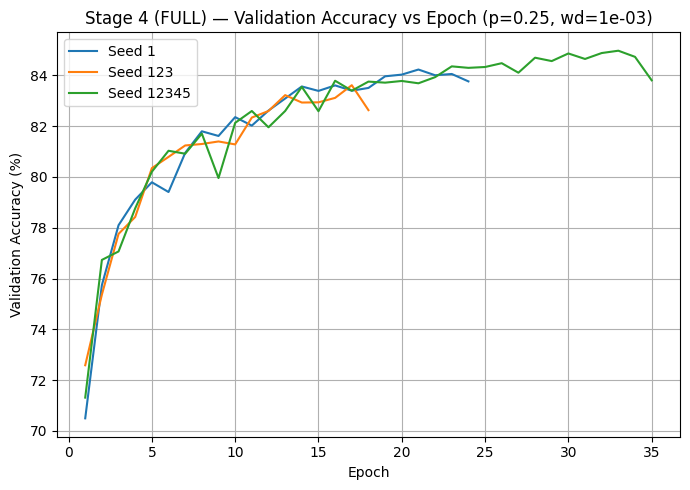

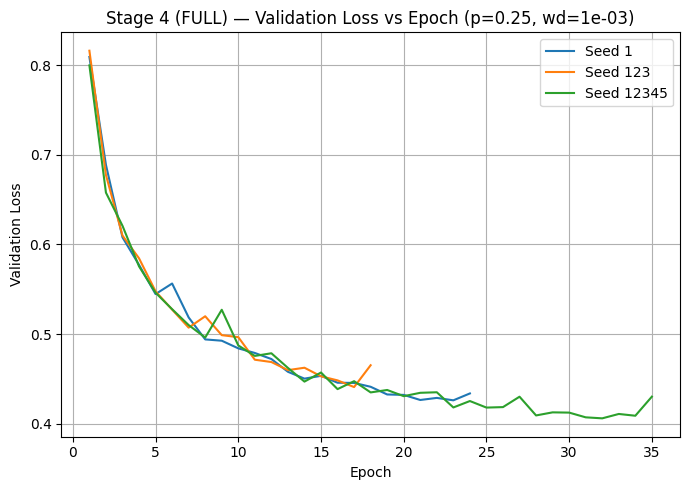

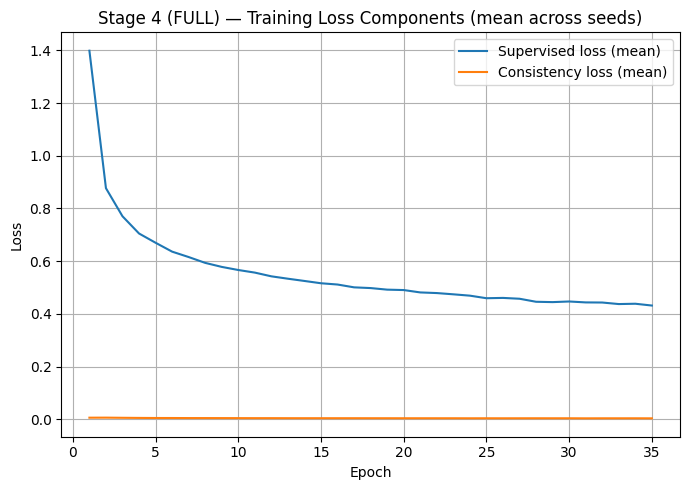

In [ ]:
# Plot 1 — Validation Accuracy curves (per seed)
plt.figure(figsize=(7,5))

for seed in seed_list:
    val_acc = histories[seed]["val_acc"]
    plt.plot(range(1, len(val_acc) + 1), val_acc, label=f"Seed {seed}")

plt.xlabel("Epoch")
plt.ylabel("Validation Accuracy (%)")
plt.title(f"Stage 4 (FULL) — Validation Accuracy vs Epoch (p={best_dropout_p}, wd={best_weight_decay:.0e})")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Plot 2 — Validation Loss curves (per seed)
plt.figure(figsize=(7,5))

for seed in seed_list:
    val_loss = histories[seed]["val_loss"]
    plt.plot(range(1, len(val_loss) + 1), val_loss, label=f"Seed {seed}")

plt.xlabel("Epoch")
plt.ylabel("Validation Loss")
plt.title(f"Stage 4 (FULL) — Validation Loss vs Epoch (p={best_dropout_p}, wd={best_weight_decay:.0e})")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



def _pad_to_max_len(curves):
    max_len = max(len(c) for c in curves)
    out = []
    for c in curves:
        if len(c) < max_len:
            c = list(c) + [np.nan] * (max_len - len(c))
        out.append(c)
    return np.array(out, dtype=float)

train_sup = _pad_to_max_len([histories[s]["train_sup_loss"] for s in seed_list])
train_cons = _pad_to_max_len([histories[s]["train_cons_loss"] for s in seed_list])

sup_mean = np.nanmean(train_sup, axis=0)
cons_mean = np.nanmean(train_cons, axis=0)

plt.figure(figsize=(7,5))
plt.plot(range(1, len(sup_mean)+1), sup_mean, label="Supervised loss (mean)")
plt.plot(range(1, len(cons_mean)+1), cons_mean, label="Consistency loss (mean)")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Stage 4 (FULL) — Training Loss Components (mean across seeds)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## Bonus Method

In [ ]:


def run_stage4_pseudolabel(
    seed: int,
    lr: float,
    momentum: float,
    max_epochs: int,
    early_stop_window: int,
    lambda_max: float,
    warmup_epochs: int,
    conf_thresh: float,
    init_mode: str,
    verbose: bool,
    save_dir: str,
    save_model: bool
) -> dict:
    """
    Stage 4A — Pseudo-Labeling 

    Total loss:
        L = L_supervised + lamda * L_pseudo
    where pseudo-labels are generated from model predictions on unlabeled data,
    but only used if max prob >= conf_thresh.

    Notes:
    - pseudo labels are fixed targets (no grad): computed in eval + no_grad
    - unlabeled batches come from unlabeled_clean_loader (no augmentation needed)

    Logging:
        - CSV per-epoch
        - JSON summary
        - Best checkpoint (optional)
    """

    set_seed(seed)
    ensure_dir(save_dir)

    run_id = make_run_id(
        "stage4pl",
        seed,
        init=init_mode,
        lr=lr,
        m=momentum,
        lmax=lambda_max,
        warm=warmup_epochs,
        thr=conf_thresh,
        win=early_stop_window
    )

    csv_path  = os.path.join(save_dir, f"{run_id}_history.csv")
    json_path = os.path.join(save_dir, f"{run_id}_summary.json")
    ckpt_path = os.path.join(save_dir, f"{run_id}_best.pt")

    print("\n")
    print("STAGE 4A (PSEUDO-LABEL) RUN CONFIG")
    print("-" * 70)
    print(f"Run ID            : {run_id}")
    print(f"Seed              : {seed}")
    print(f"Init              : {init_mode}")
    print(f"Learning rate     : {lr}")
    print(f"Momentum          : {momentum}")
    print(f"Lambda max        : {lambda_max}")
    print(f"Warmup epochs     : {warmup_epochs}")
    print(f"Conf threshold    : {conf_thresh}")
    print(f"Max epochs        : {max_epochs}")
    print(f"Early-stop window : {early_stop_window}")

    model = MLP()
    init_weights(model, init_mode)

    criterion_sup = nn.CrossEntropyLoss()
    criterion_pl  = nn.CrossEntropyLoss(reduction="mean")

    optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum)

    history = {
        "val_loss": [],
        "val_acc": [],
        "lambda": [],
        "train_sup_loss": [],
        "train_pl_loss": [],
        "train_pl_used_frac": []
    }

    with open(csv_path, "w") as f:
        f.write("epoch,lambda,train_sup_loss,train_pl_loss,pl_used_frac,val_loss,val_acc\n")

    val_errors = []
    best_val_acc = -1.0
    best_state = None
    stopped_epoch = max_epochs

    start_time = time.time()

    for epoch in range(1, max_epochs + 1):
        lam = lambda_warmup(epoch, warmup_epochs=warmup_epochs, lambda_max=lambda_max)
        model.train()

        sup_loss_sum = 0.0
        pl_loss_sum  = 0.0
        steps = 0

        pl_used = 0
        pl_total = 0

        for (x_l, y_l), (x_u, _) in zip(labeled_loader, unlabeled_clean_loader):
            optimizer.zero_grad()

            logits_l = model(x_l)
            loss_sup = criterion_sup(logits_l, y_l)

            model.eval()
            with torch.no_grad():
                logits_u = model(x_u)
                probs_u = torch.softmax(logits_u, dim=1)
                conf, y_hat = torch.max(probs_u, dim=1)   
                mask = conf >= conf_thresh

            model.train()

            if mask.any():
                logits_u_train = model(x_u)  
                loss_pl = criterion_pl(logits_u_train[mask], y_hat[mask])
                pl_used += int(mask.sum().item())
            else:
                loss_pl = torch.tensor(0.0, device=loss_sup.device)

            pl_total += int(x_u.size(0))

            # total loss
            loss = loss_sup + lam * loss_pl
            loss.backward()
            optimizer.step()

            sup_loss_sum += float(loss_sup.item())
            pl_loss_sum  += float(loss_pl.item()) if mask.any() else 0.0
            steps += 1

        train_sup_loss = sup_loss_sum / max(1, steps)
        train_pl_loss  = pl_loss_sum / max(1, steps)
        pl_used_frac   = (pl_used / pl_total) if pl_total > 0 else 0.0

        # validation
        val_loss, val_acc = evaluate_acc_loss(model, val_loader, nn.CrossEntropyLoss())

        history["lambda"].append(float(lam))
        history["train_sup_loss"].append(float(train_sup_loss))
        history["train_pl_loss"].append(float(train_pl_loss))
        history["train_pl_used_frac"].append(float(pl_used_frac))
        history["val_loss"].append(float(val_loss))
        history["val_acc"].append(float(val_acc))

        with open(csv_path, "a") as f:
            f.write(f"{epoch},{lam:.6f},{train_sup_loss:.6f},{train_pl_loss:.6f},{pl_used_frac:.6f},{val_loss:.6f},{val_acc:.4f}\n")

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_state = {k: v.detach().cpu().clone() for k, v in model.state_dict().items()}
            if save_model:
                torch.save(best_state, ckpt_path)

        val_error = 1.0 - (val_acc / 100.0)
        val_errors.append(val_error)

        if len(val_errors) >= early_stop_window + 1:
            recent = np.array(val_errors[-(early_stop_window + 1):-1])
            if val_error > (recent.mean() + recent.std()):
                stopped_epoch = epoch
                if verbose:
                    print(f"EARLY STOP at epoch {epoch} | λ={lam:.3f} | Val Acc: {val_acc:.2f}%")
                break

        if verbose:
            print(f"Epoch {epoch}/{max_epochs} | λ={lam:.3f} | Val Acc: {val_acc:.2f}% | PL used {pl_used_frac*100:.1f}%")

    train_time_sec = time.time() - start_time

    if best_state is None:
        best_state = {k: v.detach().cpu().clone() for k, v in model.state_dict().items()}
    model.load_state_dict(best_state)

    _, test_acc = evaluate_acc_loss(model, test_loader, nn.CrossEntropyLoss())

    summary = {
        "run_id": run_id,
        "stage": "stage4_pseudolabel",
        "seed": seed,
        "init_mode": init_mode,
        "lr": lr,
        "momentum": momentum,
        "lambda_max": lambda_max,
        "warmup_epochs": warmup_epochs,
        "conf_thresh": conf_thresh,
        "max_epochs": max_epochs,
        "early_stop_window": early_stop_window,
        "stopped_epoch": stopped_epoch,
        "best_val_acc": float(best_val_acc),
        "test_acc": float(test_acc),
        "train_time_sec": float(train_time_sec),
        "history_csv": csv_path,
        "summary_json": json_path,
        "best_model_path": ckpt_path if save_model else None,
        "timestamp": datetime.now().isoformat(timespec="seconds")
    }

    with open(json_path, "w") as f:
        json.dump(summary, f, indent=2)

    return {
        "seed": seed,
        "run_id": run_id,
        "stopped_epoch": stopped_epoch,
        "best_val_acc": best_val_acc,
        "test_acc": test_acc,
        "train_time_sec": train_time_sec,
        "history": history,
        "history_csv": csv_path,
        "summary_json": json_path,
        "best_model_path": ckpt_path if save_model else None
    }

In [90]:

save_dir = "./results/stage4_pseudolabel_multiseed"
os.makedirs(save_dir, exist_ok=True)

seed_list = [1, 123, 12345]
histories = {}
test_accuracies = []
train_times = []
run_ids = []

for seed in seed_list:
    result = run_stage4_pseudolabel(
        seed=seed,
        init_mode="he",
        lr=0.01,
        momentum=0.9,
        max_epochs=50,
        early_stop_window=5,
        lambda_max=1.0,
        warmup_epochs=20,
        conf_thresh=0.90,
        verbose=False,
        save_dir="./results/stage4_pseudolabel",
        save_model=True
    )

    histories[seed] = result["history"]
    test_accuracies.append(result["test_acc"])
    train_times.append(result["train_time_sec"])
    run_ids.append(result["run_id"])

    print(
        f"Seed {seed} | "
        f"stop@{result['stopped_epoch']} | "
        f"best val {result['best_val_acc']:.2f}% | "
        f"test {result['test_acc']:.2f}% | "
        f"run_id {result['run_id']}"
    )

mean_acc = float(np.mean(test_accuracies))
std_acc  = float(np.std(test_accuracies, ddof=1))
mean_time = float(np.mean(train_times))

print(f"\nStage 4A (Pseudo-Label) Test Accuracy: {mean_acc:.2f}% ± {std_acc:.2f}%")
print(f"Average Training Time            : {mean_time:.2f} sec")



# Save multiseed CSV/JSON
csv_path = os.path.join(save_dir, "stage4_pseudolabel_multiseed_summary.csv")
with open(csv_path, "w") as f:
    f.write("seed,test_acc,train_time_sec,run_id\n")
    for s, acc, t, rid in zip(seed_list, test_accuracies, train_times, run_ids):
        f.write(f"{s},{acc:.4f},{t:.4f},{rid}\n")
    f.write(f"\nmean,{mean_acc:.4f},,\n")
    f.write(f"std,{std_acc:.4f},,\n")
print(f"Saved CSV: {csv_path}")

json_path = os.path.join(save_dir, "stage4_pseudolabel_multiseed_summary.json")
with open(json_path, "w") as f:
    json.dump({
        "stage": "stage4_pseudolabel",
        "seeds": seed_list,
        "test_accuracies": [float(x) for x in test_accuracies],
        "mean_test_accuracy": mean_acc,
        "std_test_accuracy": std_acc,
        "mean_train_time_sec": mean_time,
        "run_ids": run_ids
    }, f, indent=2)
print(f"Saved JSON: {json_path}")



STAGE 4A (PSEUDO-LABEL) RUN CONFIG
----------------------------------------------------------------------
Run ID            : stage4pl_seed1_inithe_lr0.01_m0.9_lmax1_warm20_thr0.9_win5
Seed              : 1
Init              : he
Learning rate     : 0.01
Momentum          : 0.9
Lambda max        : 1.0
Warmup epochs     : 20
Conf threshold    : 0.9
Max epochs        : 50
Early-stop window : 5
Seed 1 | stop@11 | best val 85.64% | test 84.16% | run_id stage4pl_seed1_inithe_lr0.01_m0.9_lmax1_warm20_thr0.9_win5


STAGE 4A (PSEUDO-LABEL) RUN CONFIG
----------------------------------------------------------------------
Run ID            : stage4pl_seed123_inithe_lr0.01_m0.9_lmax1_warm20_thr0.9_win5
Seed              : 123
Init              : he
Learning rate     : 0.01
Momentum          : 0.9
Lambda max        : 1.0
Warmup epochs     : 20
Conf threshold    : 0.9
Max epochs        : 50
Early-stop window : 5
Seed 123 | stop@26 | best val 87.47% | test 86.43% | run_id stage4pl_seed123_inithe_l

## Graph Plotation

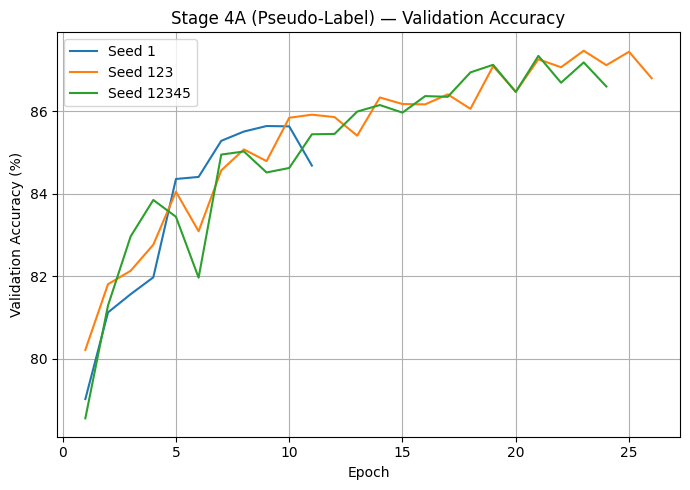

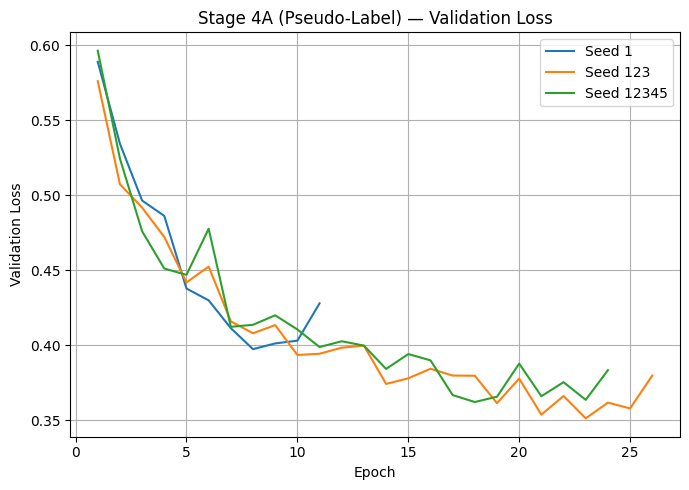

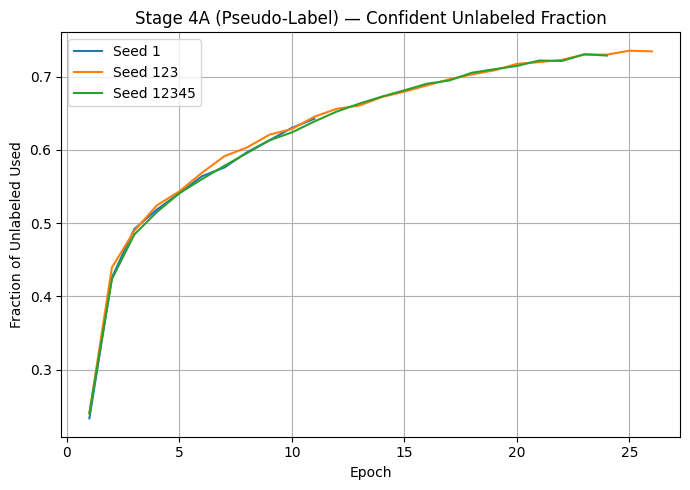

In [91]:
# Curves: Validation Accuracy
plt.figure(figsize=(7,5))
for seed in seed_list:
    val_acc = histories[seed]["val_acc"]
    plt.plot(range(1, len(val_acc)+1), val_acc, label=f"Seed {seed}")
plt.xlabel("Epoch")
plt.ylabel("Validation Accuracy (%)")
plt.title("Stage 4A (Pseudo-Label) — Validation Accuracy")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Curves: Validation Loss
plt.figure(figsize=(7,5))
for seed in seed_list:
    val_loss = histories[seed]["val_loss"]
    plt.plot(range(1, len(val_loss)+1), val_loss, label=f"Seed {seed}")
plt.xlabel("Epoch")
plt.ylabel("Validation Loss")
plt.title("Stage 4A (Pseudo-Label) — Validation Loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Curves: Pseudo-label usage fraction
plt.figure(figsize=(7,5))
for seed in seed_list:
    frac = histories[seed]["train_pl_used_frac"]
    plt.plot(range(1, len(frac)+1), frac, label=f"Seed {seed}")
plt.xlabel("Epoch")
plt.ylabel("Fraction of Unlabeled Used")
plt.title("Stage 4A (Pseudo-Label) — Confident Unlabeled Fraction")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
def mean_std(values):
    return float(np.mean(values)), float(np.std(values, ddof=1))

def run_many(runner_fn, seeds, **kwargs):
    """Run the same experiment across multiple seeds and return results."""
    results = []
    for seed in seeds:
        out = runner_fn(seed=seed, **kwargs)
        results.append(out)
    return results

def summarize_runs(runs):
    """Extract mean/std for test_acc and train_time_sec."""
    test_accs = [r["test_acc"] for r in runs]
    times = [r.get("train_time_sec", np.nan) for r in runs]
    mu_acc, sd_acc = mean_std(test_accs)
    mu_time, sd_time = mean_std(times) if not np.isnan(times).any() else (float(np.nan), float(np.nan))
    return mu_acc, sd_acc, mu_time, sd_time

## Defines Full PipeLine for Pesudoline

In [ ]:

def run_stage4_pseudolabel_full(
    seed: int,
    dropout_p: float,
    weight_decay: float,
    lr: float,
    momentum: float,
    max_epochs: int,
    early_stop_window: int,
    # pseudo-label controls
    conf_threshold: float = 0.95,
    lambda_u_max: float = 1.0,
    warmup_epochs: int = 10,
    verbose: bool = True,
    save_dir: str = "./results/stage4_pseudolabel_full",
    save_model: bool = True
) -> dict:
    """
    Stage 4 FULL — Pseudo-Labeling + Dropout + Weight Decay.
      - pseudo-label targets are treated as fixed (detach)
      - uses unlabeled_clean_loader as x_u source
    """

    set_seed(seed)
    ensure_dir(save_dir)

    run_id = make_run_id(
        "stage4plfull",
        seed,
        p=dropout_p,
        wd=weight_decay,
        lr=lr,
        m=momentum,
        th=conf_threshold,
        lmax=lambda_u_max,
        warm=warmup_epochs,
        win=early_stop_window
    )

    csv_path  = os.path.join(save_dir, f"{run_id}_history.csv")
    json_path = os.path.join(save_dir, f"{run_id}_summary.json")
    ckpt_path = os.path.join(save_dir, f"{run_id}_best.pt")

    print("\n")
    print("STAGE 4 (FULL: PSEUDO-LABEL + DROPOUT + WEIGHT DECAY) RUN CONFIG")
    print("-" * 70)
    print(f"Run ID            : {run_id}")
    print(f"Seed              : {seed}")
    print(f"Dropout p         : {dropout_p}")
    print(f"Weight decay (λ)  : {weight_decay}")
    print(f"Learning rate     : {lr}")
    print(f"Momentum          : {momentum}")
    print(f"Conf threshold    : {conf_threshold}")
    print(f"Lambda_u max      : {lambda_u_max}")
    print(f"Warmup epochs     : {warmup_epochs}")
    print(f"Max epochs        : {max_epochs}")
    print(f"Early-stop window : {early_stop_window}")

    model = MLPDropout(dropout_p=dropout_p)
    init_weights(model, "he")

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(
        model.parameters(),
        lr=lr,
        momentum=momentum,
        weight_decay=weight_decay
    )

    history = {
        "train_total_loss": [],
        "train_sup_loss": [],
        "train_pseudo_loss": [],
        "pseudo_kept_frac": [],
        "val_loss": [],
        "val_acc": [],
        "lambda_u": []
    }

    with open(csv_path, "w") as f:
        f.write("epoch,lambda_u,train_total_loss,train_sup_loss,train_pseudo_loss,pseudo_kept_frac,val_loss,val_acc\n")

    val_errors = []
    best_val_acc = -1.0
    best_state = None
    stopped_epoch = max_epochs
    start_time = time.time()

    # You must have unlabeled_clean_loader defined for Stage 4
    if "unlabeled_clean_loader" not in globals():
        raise NameError("unlabeled_clean_loader is not defined. Build it from your unlabeled indices first.")

    for epoch in range(1, max_epochs + 1):
        lam_u = lambda_warmup(epoch, warmup_epochs=warmup_epochs, lambda_max=lambda_u_max)
        model.train()

        total_loss_sum = 0.0
        sup_loss_sum = 0.0
        pseudo_loss_sum = 0.0
        kept_sum = 0
        total_u_sum = 0
        steps = 0

        for (x_l, y_l), (x_u, _) in zip(labeled_loader, unlabeled_clean_loader):
            optimizer.zero_grad()

            logits_l = model(x_l)
            loss_sup = criterion(logits_l, y_l)

            model.eval()
            with torch.no_grad():
                logits_u = model(x_u)
                probs_u = torch.softmax(logits_u, dim=1)
                conf_u, y_hat = torch.max(probs_u, dim=1)
            model.train()

            mask = conf_u >= conf_threshold
            total_u = x_u.size(0)
            kept = int(mask.sum().item())

            if kept > 0:
                logits_u_train = model(x_u[mask])
                loss_pseudo = criterion(logits_u_train, y_hat[mask].detach())
            else:
                loss_pseudo = torch.tensor(0.0, device=x_u.device)

            loss = loss_sup + lam_u * loss_pseudo
            loss.backward()
            optimizer.step()

            total_loss_sum += float(loss.item())
            sup_loss_sum += float(loss_sup.item())
            pseudo_loss_sum += float(loss_pseudo.item())
            kept_sum += kept
            total_u_sum += total_u
            steps += 1

        train_total_loss = total_loss_sum / max(1, steps)
        train_sup_loss   = sup_loss_sum / max(1, steps)
        train_pseudo_loss= pseudo_loss_sum / max(1, steps)
        kept_frac = (kept_sum / max(1, total_u_sum)) if total_u_sum > 0 else 0.0

        val_loss, val_acc = evaluate_acc_loss(model, val_loader, criterion)

        history["train_total_loss"].append(train_total_loss)
        history["train_sup_loss"].append(train_sup_loss)
        history["train_pseudo_loss"].append(train_pseudo_loss)
        history["pseudo_kept_frac"].append(kept_frac)
        history["val_loss"].append(val_loss)
        history["val_acc"].append(val_acc)
        history["lambda_u"].append(lam_u)

        with open(csv_path, "a") as f:
            f.write(
                f"{epoch},{lam_u:.6f},{train_total_loss:.6f},{train_sup_loss:.6f},"
                f"{train_pseudo_loss:.6f},{kept_frac:.6f},{val_loss:.6f},{val_acc:.4f}\n"
            )

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_state = {k: v.detach().cpu().clone() for k, v in model.state_dict().items()}
            if save_model:
                torch.save(best_state, ckpt_path)

        val_error = 1.0 - (val_acc / 100.0)
        val_errors.append(val_error)

        if len(val_errors) >= early_stop_window + 1:
            recent = np.array(val_errors[-(early_stop_window + 1):-1])
            if val_error > (recent.mean() + recent.std()):
                stopped_epoch = epoch
                if verbose:
                    print(
                        f"EARLY STOP at epoch {epoch} | λ_u={lam_u:.3f} | "
                        f"Val Acc: {val_acc:.2f}% | kept={kept_frac*100:.1f}%"
                    )
                break

        if verbose:
            print(
                f"Epoch {epoch}/{max_epochs} | λ_u={lam_u:.3f} | "
                f"Val Acc: {val_acc:.2f}% | kept={kept_frac*100:.1f}%"
            )

    train_time_sec = time.time() - start_time

    if best_state is None:
        best_state = {k: v.detach().cpu().clone() for k, v in model.state_dict().items()}
    model.load_state_dict(best_state)

    _, test_acc = evaluate_acc_loss(model, test_loader, nn.CrossEntropyLoss())

    summary = {
        "run_id": run_id,
        "stage": "stage4_pseudolabel_full",
        "seed": seed,
        "dropout_p": dropout_p,
        "weight_decay": weight_decay,
        "lr": lr,
        "momentum": momentum,
        "conf_threshold": conf_threshold,
        "lambda_u_max": lambda_u_max,
        "warmup_epochs": warmup_epochs,
        "max_epochs": max_epochs,
        "early_stop_window": early_stop_window,
        "stopped_epoch": stopped_epoch,
        "best_val_acc": float(best_val_acc),
        "test_acc": float(test_acc),
        "train_time_sec": float(train_time_sec),
        "history_csv": csv_path,
        "summary_json": json_path,
        "best_model_path": ckpt_path if save_model else None,
        "timestamp": datetime.now().isoformat(timespec="seconds")
    }

    with open(json_path, "w") as f:
        json.dump(summary, f, indent=2)

    return {
        "seed": seed,
        "dropout_p": dropout_p,
        "weight_decay": weight_decay,
        "lr": lr,
        "momentum": momentum,
        "conf_threshold": conf_threshold,
        "lambda_u_max": lambda_u_max,
        "warmup_epochs": warmup_epochs,
        "stopped_epoch": stopped_epoch,
        "best_val_acc": best_val_acc,
        "test_acc": test_acc,
        "train_time_sec": train_time_sec,
        "history": history,
        "run_id": run_id,
        "history_csv": csv_path,
        "summary_json": json_path,
        "best_model_path": ckpt_path if save_model else None
    }

## Runs Full Pipeline for PesudoLabel

In [ ]:

save_dir = "./results/stage4_pseudolabel_full_multiseed"
os.makedirs(save_dir, exist_ok=True)

seed_list = [1, 123, 12345]
histories = {}
test_accuracies = []
train_times = []
run_ids = []

for seed in seed_list:
    result = run_stage4_pseudolabel_full(
        seed=seed,
        dropout_p=0.25,
        weight_decay=1e-3,
        lr=0.01,
        momentum=0.9,
        max_epochs=50,
        early_stop_window=5,
        conf_threshold=0.95,
        lambda_u_max=1.0,
        warmup_epochs=20,
        verbose=False,
        save_dir="./results/stage4_pseudolabel_full",
        save_model=True
    )

    histories[seed] = result["history"]
    test_accuracies.append(result["test_acc"])
    train_times.append(result["train_time_sec"])
    run_ids.append(result["run_id"])

    print(
        f"Seed {seed} | "
        f"stop@{result['stopped_epoch']} | "
        f"best val {result['best_val_acc']:.2f}% | "
        f"test {result['test_acc']:.2f}% | "
        f"run_id {result['run_id']}"
    )

mean_acc = float(np.mean(test_accuracies))
std_acc  = float(np.std(test_accuracies, ddof=1))
mean_time = float(np.mean(train_times))

print(f"\nStage 4 (FULL PSEUDO-LABEL) Test Accuracy: {mean_acc:.2f}% ± {std_acc:.2f}%")
print(f"Average Training Time              : {mean_time:.2f} sec")

# Save summary CSV
csv_path = os.path.join(save_dir, "stage4_pseudolabel_full_multiseed_summary.csv")
with open(csv_path, "w") as f:
    f.write("seed,test_acc,train_time_sec,run_id\n")
    for s, acc, t, rid in zip(seed_list, test_accuracies, train_times, run_ids):
        f.write(f"{s},{acc:.4f},{t:.4f},{rid}\n")
    f.write(f"\nmean,{mean_acc:.4f},,\n")
    f.write(f"std,{std_acc:.4f},,\n")
print(f"Saved CSV: {csv_path}")

# Save summary JSON
json_path = os.path.join(save_dir, "stage4_pseudolabel_full_multiseed_summary.json")
summary_data = {
    "stage": "stage4_pseudolabel_full",
    "seeds": seed_list,
    "test_accuracies": test_accuracies,
    "mean_test_accuracy": mean_acc,
    "std_test_accuracy": std_acc,
    "mean_train_time_sec": mean_time,
    "run_ids": run_ids
}
with open(json_path, "w") as f:
    json.dump(summary_data, f, indent=2)
print(f"Saved JSON: {json_path}")





STAGE 4 (FULL: PSEUDO-LABEL + DROPOUT + WEIGHT DECAY) RUN CONFIG
----------------------------------------------------------------------
Run ID            : stage4plfull_seed1_p0.25_wd0.001_lr0.01_m0.9_th0.95_lmax1_warm20_win5
Seed              : 1
Dropout p         : 0.25
Weight decay (λ)  : 0.001
Learning rate     : 0.01
Momentum          : 0.9
Conf threshold    : 0.95
Lambda_u max      : 1.0
Warmup epochs     : 20
Max epochs        : 50
Early-stop window : 5
Seed 1 | stop@36 | best val 87.10% | test 85.53% | run_id stage4plfull_seed1_p0.25_wd0.001_lr0.01_m0.9_th0.95_lmax1_warm20_win5


STAGE 4 (FULL: PSEUDO-LABEL + DROPOUT + WEIGHT DECAY) RUN CONFIG
----------------------------------------------------------------------
Run ID            : stage4plfull_seed123_p0.25_wd0.001_lr0.01_m0.9_th0.95_lmax1_warm20_win5
Seed              : 123
Dropout p         : 0.25
Weight decay (λ)  : 0.001
Learning rate     : 0.01
Momentum          : 0.9
Conf threshold    : 0.95
Lambda_u max      : 1.0
Wa

## Graph Plotation

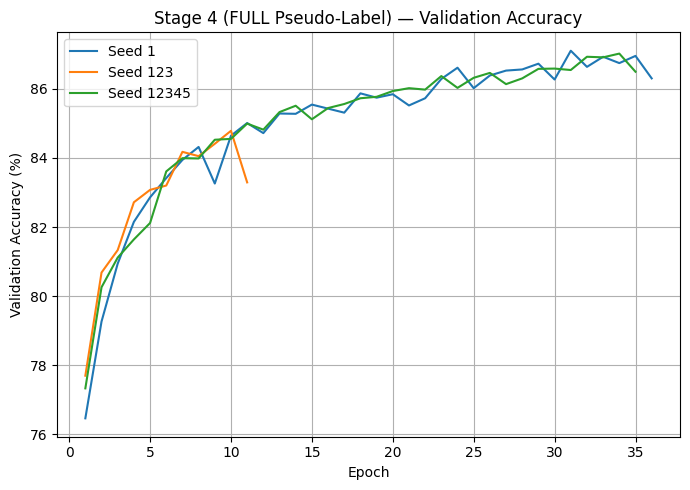

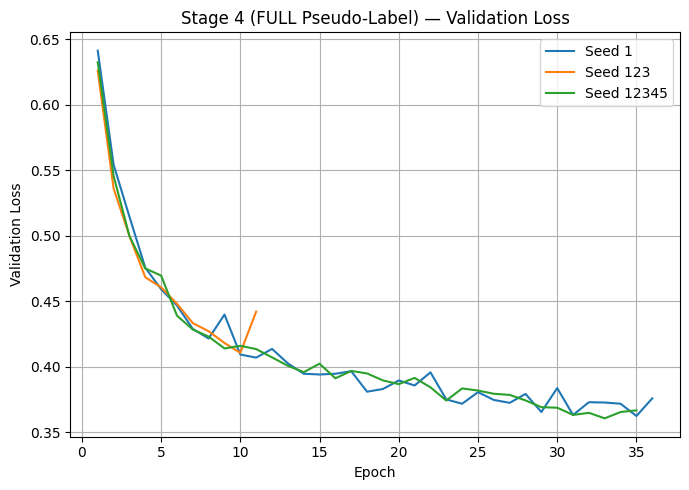

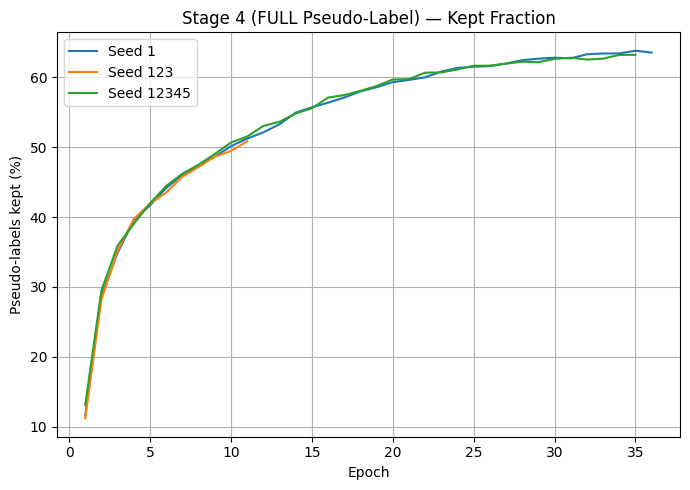

In [ ]:
# Plot 1: Validation Accuracy
plt.figure(figsize=(7,5))
for seed in seed_list:
    val_acc = histories[seed]["val_acc"]
    plt.plot(range(1, len(val_acc)+1), val_acc, label=f"Seed {seed}")
plt.xlabel("Epoch")
plt.ylabel("Validation Accuracy (%)")
plt.title("Stage 4 (FULL Pseudo-Label) — Validation Accuracy")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# -------------------------------
# Plot 2: Validation Loss
# -------------------------------
plt.figure(figsize=(7,5))
for seed in seed_list:
    val_loss = histories[seed]["val_loss"]
    plt.plot(range(1, len(val_loss)+1), val_loss, label=f"Seed {seed}")
plt.xlabel("Epoch")
plt.ylabel("Validation Loss")
plt.title("Stage 4 (FULL Pseudo-Label) — Validation Loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# -------------------------------
# Plot 3: Pseudo kept fraction (%)
# -------------------------------
plt.figure(figsize=(7,5))
for seed in seed_list:
    kept = [k*100 for k in histories[seed]["pseudo_kept_frac"]]
    plt.plot(range(1, len(kept)+1), kept, label=f"Seed {seed}")
plt.xlabel("Epoch")
plt.ylabel("Pseudo-labels kept (%)")
plt.title("Stage 4 (FULL Pseudo-Label) — Kept Fraction")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## Stage 5A — Component Contribution (Ablation Table)

We quantify the contribution of each pipeline component by comparing test accuracy
(mean ± std over 3 seeds) and reporting the improvement relative to baseline.

Configuration order:
1) Baseline (Stage 2)
2) + Better Initialization (if baseline didn’t already use the best one)
3) + Regularization Technique 1 (Dropout)
4) + Regularization Technique 2 (Weight Decay)
5) + Semi-Supervised Learning (Consistency, Stage 4)
6) Full Pipeline (best combination)

In [ ]:
from torchvision import datasets, transforms

# If you're using FashionMNIST / MNIST
raw_transform = transforms.ToTensor()

train_raw = datasets.FashionMNIST(
    root="./data",
    train=True,
    download=True,
    transform=raw_transform
)

100%|██████████| 26.4M/26.4M [00:38<00:00, 678kB/s] 
100%|██████████| 29.5k/29.5k [00:00<00:00, 265kB/s]
100%|██████████| 4.42M/4.42M [00:04<00:00, 900kB/s] 
100%|██████████| 5.15k/5.15k [00:00<00:00, 6.70MB/s]


In [ ]:
import os, json
import numpy as np
import torch
from torch.utils.data import DataLoader, Subset

# Helpers
def mean_std(vals):
    return float(np.mean(vals)), float(np.std(vals, ddof=1))

def fmt(mu, sd):
    return f"{mu:.2f} ± {sd:.2f}"

def run_many(runner_fn, seeds, **kwargs):
    outs = []
    for s in seeds:
        outs.append(runner_fn(seed=s, **kwargs))
    return outs

def summarize_runs(runs):
    test_accs = [r["test_acc"] for r in runs]
    times = [r.get("train_time_sec", np.nan) for r in runs]
    mu, sd = mean_std(test_accs)
    tmu = float(np.mean(times)) if not np.isnan(times).any() else float(np.nan)
    return mu, sd, tmu

def print_seed_lines(runs):
    for r in runs:
        print(
            f"Seed {r['seed']} | "
            f"stop@{r['stopped_epoch']} | "
            f"best val {r['best_val_acc']:.2f}% | "
            f"test {r['test_acc']:.2f}%"
        )

# Loader builders
def make_train_loader(dataset, indices, batch_size=128, shuffle=True):
    ds = Subset(dataset, indices)
    return DataLoader(ds, batch_size=batch_size, shuffle=shuffle)

def set_stage4_loaders(labeled_idx, unlabeled_idx, batch_size=128):
    global labeled_loader, unlabeled_clean_loader, unlabeled_aug_loader

    labeled_aug = Subset(train_augmented, labeled_idx)
    labeled_loader = DataLoader(labeled_aug, batch_size=batch_size, shuffle=True)

    unlabeled_clean = Subset(train_minmax, unlabeled_idx)
    unlabeled_aug = Subset(train_augmented, unlabeled_idx)

    unlabeled_clean_loader = DataLoader(unlabeled_clean, batch_size=batch_size, shuffle=False, drop_last=True)
    unlabeled_aug_loader   = DataLoader(unlabeled_aug,   batch_size=batch_size, shuffle=False, drop_last=True)

# Stage 5A runner
def run_stage5a_component_contribution(
    seeds=(1, 123, 12345),
    batch_size=128,
    lr=0.01,
    momentum=0.9,
    max_epochs=50,
    early_stop_window=5,
    dropout_p=0.25,
    weight_decay=1e-3,
    lambda_max=1.0,
    warmup_epochs=10,
    save_root="./results/stage5a",
    verbose=False
):
    os.makedirs(save_root, exist_ok=True)

    # Stage 4 loaders (10% labeled, 90% unlabeled)
    set_stage4_loaders(labeled_indices, unlabeled_indices, batch_size=batch_size)

    rows = []

    # we temporarily swap the global train_loader for stage 2/3
    _old_train_loader = globals().get("train_loader", None)

    # 1) Baseline (no preprocessing) — RAW + uniform init
    print("\nBaseline (10% labeled, no preprocessing / RAW, uniform init)")
    train_loader_raw = make_train_loader(train_raw, labeled_indices, batch_size=batch_size, shuffle=True)
    globals()["train_loader"] = train_loader_raw

    baseline_runs = run_many(
        run_stage2,
        seeds,
        init_mode="uniform_fanin",
        lr=lr, momentum=momentum,
        max_epochs=max_epochs,
        early_stop_window=early_stop_window,
        verbose=verbose,
        save_dir="./results/stage2_raw",
        save_model=True
    )
    print_seed_lines(baseline_runs)
    base_mu, base_sd, base_t = summarize_runs(baseline_runs)
    rows.append(("Baseline (RAW, uniform)", base_mu, base_sd, 0.0))

    # 2) Preprocessing — min-max + uniform init
    print("\n+ Preprocessing (min-max, still uniform init)")
    train_loader_pre = make_train_loader(train_minmax, labeled_indices, batch_size=batch_size, shuffle=True)
    globals()["train_loader"] = train_loader_pre

    pre_runs = run_many(
        run_stage2,
        seeds,
        init_mode="uniform_fanin",
        lr=lr, momentum=momentum,
        max_epochs=max_epochs,
        early_stop_window=early_stop_window,
        verbose=verbose,
        save_dir="./results/stage2_pre",
        save_model=True
    )
    print_seed_lines(pre_runs)
    pre_mu, pre_sd, pre_t = summarize_runs(pre_runs)
    rows.append(("+ Preprocessing (min-max)", pre_mu, pre_sd, pre_mu - base_mu))

    # 3) Better Initialization — min-max + He init
    print("\n+ Better Initialization (He, with preprocessing)")
    he_runs = run_many(
        run_stage2,
        seeds,
        init_mode="he",
        lr=lr, momentum=momentum,
        max_epochs=max_epochs,
        early_stop_window=early_stop_window,
        verbose=verbose,
        save_dir="./results/stage2_he",
        save_model=True
    )
    print_seed_lines(he_runs)
    he_mu, he_sd, he_t = summarize_runs(he_runs)
    rows.append(("+ Better Init (He)", he_mu, he_sd, he_mu - base_mu))

    # 4) Regularization 1 — Dropout
    print(f"\n+ Regularization 1 (Dropout p={dropout_p})")
    drop_runs = run_many(
        run_stage3_dropout,
        seeds,
        dropout_p=dropout_p,
        init_mode="he",
        lr=lr, momentum=momentum,
        max_epochs=max_epochs,
        early_stop_window=early_stop_window,
        verbose=verbose,
        save_dir="./results/stage3_dropout",
        save_model=True
    )
    print_seed_lines(drop_runs)
    drop_mu, drop_sd, drop_t = summarize_runs(drop_runs)
    rows.append((f"+ Dropout (p={dropout_p})", drop_mu, drop_sd, drop_mu - base_mu))

    # 5) Regularization 2 — Weight Decay
    print(f"\n+ Regularization 2 (Weight Decay λ={weight_decay:.0e})")
    wd_runs = run_many(
        run_stage3_weight_decay,
        seeds,
        weight_decay=weight_decay,
        init_mode="he",
        lr=lr, momentum=momentum,
        max_epochs=max_epochs,
        early_stop_window=early_stop_window,
        verbose=verbose,
        save_dir="./results/stage3_weight_decay",
        save_model=True
    )
    print_seed_lines(wd_runs)
    wd_mu, wd_sd, wd_t = summarize_runs(wd_runs)
    rows.append((f"+ Weight Decay (λ={weight_decay:.0e})", wd_mu, wd_sd, wd_mu - base_mu))

    # restore stage2/3 global train_loader
    if _old_train_loader is not None:
        globals()["train_loader"] = _old_train_loader

    # 6) + Semi-supervised — Stage 4 CORE (Method C only)
    print("\n+ Semi-Supervised (Consistency CORE / Method C only)")
    ssl_core_runs = run_many(
        run_stage4_consistency_core,
        seeds,
        lr=lr,
        momentum=momentum,
        max_epochs=max_epochs,
        early_stop_window=early_stop_window,
        lambda_max=lambda_max,
        warmup_epochs=warmup_epochs,
        verbose=verbose,
        save_dir="./results/stage4_core",
        save_model=True
    )
    print_seed_lines(ssl_core_runs)
    ssl_mu, ssl_sd, ssl_t = summarize_runs(ssl_core_runs)
    rows.append(("+ Consistency CORE", ssl_mu, ssl_sd, ssl_mu - base_mu))

    # 7) Full pipeline — Stage 4 FULL (Method C + dropout + weight decay)
    print("\nFull Pipeline (Consistency FULL + Dropout + Weight Decay)")
    ssl_full_runs = run_many(
        run_stage4_consistency_full,
        seeds,
        dropout_p=dropout_p,
        weight_decay=weight_decay,
        lr=lr,
        momentum=momentum,
        max_epochs=max_epochs,
        early_stop_window=early_stop_window,
        lambda_max=lambda_max,
        warmup_epochs=warmup_epochs,
        verbose=verbose,
        save_dir="./results/stage4_full",
        save_model=True
    )
    print_seed_lines(ssl_full_runs)
    full_mu, full_sd, full_t = summarize_runs(ssl_full_runs)
    rows.append(("Full Pipeline", full_mu, full_sd, full_mu - base_mu))

    # Final table
    print("\nComponent Contribution Table")
    print("Configuration | Test Acc (µ±σ) | Improvement")
    for name, mu, sd, imp in rows:
        print(f"{name} | {fmt(mu, sd)} | {imp:+.2f}%")

    out = {
        "seeds": list(seeds),
        "baseline_mu": float(base_mu),
        "baseline_sd": float(base_sd),
        "rows": [
            {"config": n, "mu": float(mu), "sd": float(sd), "improvement": float(imp)}
            for (n, mu, sd, imp) in rows
        ]
    }

    out_path = os.path.join(save_root, "stage5a_component_contribution.json")
    with open(out_path, "w") as f:
        json.dump(out, f, indent=2)
    print(f"\nSaved: {out_path}")

    return out


# Main runner
results_5a = run_stage5a_component_contribution()



STAGE 2 RUN CONFIG
----------------------------------------------------------------------
Run ID            : stage2_seed1_inituniform_fanin_lr0.01_m0.9_win5
Seed              : 1
Init              : uniform_fanin
Learning rate     : 0.01
Momentum          : 0.9
Max epochs        : 50
Early-stop window : 5


STAGE 2 RUN CONFIG
----------------------------------------------------------------------
Run ID            : stage2_seed123_inituniform_fanin_lr0.01_m0.9_win5
Seed              : 123
Init              : uniform_fanin
Learning rate     : 0.01
Momentum          : 0.9
Max epochs        : 50
Early-stop window : 5


STAGE 2 RUN CONFIG
----------------------------------------------------------------------
Run ID            : stage2_seed12345_inituniform_fanin_lr0.01_m0.9_win5
Seed              : 12345
Init              : uniform_fanin
Learning rate     : 0.01
Momentum          : 0.9
Max epochs        : 50
Early-stop window : 5


STAGE 2 RUN CONFIG
-------------------------------------



STAGE 2 RUN CONFIG
----------------------------------------------------------------------
Run ID            : stage2_seed1_inituniform_fanin_lr0.01_m0.9_win5
Seed              : 1
Init              : uniform_fanin
Learning rate     : 0.01
Momentum          : 0.9
Max epochs        : 50
Early-stop window : 5


STAGE 2 RUN CONFIG
----------------------------------------------------------------------
Run ID            : stage2_seed123_inituniform_fanin_lr0.01_m0.9_win5
Seed              : 123
Init              : uniform_fanin
Learning rate     : 0.01
Momentum          : 0.9
Max epochs        : 50
Early-stop window : 5


STAGE 2 RUN CONFIG
----------------------------------------------------------------------
Run ID            : stage2_seed12345_inituniform_fanin_lr0.01_m0.9_win5
Seed              : 12345
Init              : uniform_fanin
Learning rate     : 0.01
Momentum          : 0.9
Max epochs        : 50
Early-stop window : 5


STAGE 2 RUN CONFIG
-------------------------------------

KeyboardInterrupt: 

## Stage 5B — Fully Supervised Upper Bound (100% Labeled)

We train the same best model using 100% of the training labels to estimate an upper bound.
We then compare how close the semi-supervised pipeline (10% labeled + unlabeled data) gets to it.

In [ ]:
# Stage 5B — Upper Bound Comparison 
# Fully supervised (100% labels) vs semi-supervised (10% labels)
import os, json
import numpy as np
from torch.utils.data import DataLoader, Subset

save_dir = "./results/stage5b_upper_bound"
os.makedirs(save_dir, exist_ok=True)

#  semi-supervised  result from Stage 4 FULL is directly used here to save rerunning time
ssl_mu = 83.13
ssl_sd = 0.58

seeds = [1, 123, 12345]

full_labeled_augmented = Subset(train_augmented, train_pool_indices)
full_train_loader = DataLoader(full_labeled_augmented, batch_size=128, shuffle=True)

print(f"Fully supervised (100% labels)")
print(f"Train samples: {len(full_labeled_augmented)}")
print(f"Train batches: {len(full_train_loader)}\n")

# temporarily swap global train_loader because Stage 3 uses train_loader 
_old_train_loader = globals().get("train_loader", None)
globals()["train_loader"] = full_train_loader

# run Stage 3 Dropout as the best supervised model 
best_supervised_runs = run_many(
    run_stage3_dropout,
    seeds,
    dropout_p=0.25,
    init_mode="he",
    lr=0.01,
    momentum=0.9,
    max_epochs=50,
    early_stop_window=5,
    verbose=False,
    save_dir="./results/stage3_dropout_full_supervised",
    save_model=True
)

# restore train_loader
if _old_train_loader is not None:
    globals()["train_loader"] = _old_train_loader

# summarize
full_mu, full_sd, full_time_mu = summarize_runs(best_supervised_runs)

gap = float(full_mu - ssl_mu)
pct_of_upper = float(100.0 * ssl_mu / full_mu)

print("RESULTS (Upper Bound Comparison)")
print(f"Best supervised model (100% labels): Stage 3 Dropout (p=0.25)")
print(f"Fully Supervised Test Accuracy      : {full_mu:.2f}% ± {full_sd:.2f}%")
print(f"Semi-supervised (10% labels)        : {ssl_mu:.2f}% ± {ssl_sd:.2f}%")
print(f"Gap to upper bound                  : {gap:+.2f} percentage points")
print(f"Semi-supervised as % of upper bound : {pct_of_upper:.1f}%")

# save json
out = {
    "seeds": seeds,
    "best_supervised_name": "Stage 3 Dropout (p=0.25)",
    "full_supervised_mu": float(full_mu),
    "full_supervised_sd": float(full_sd),
    "ssl_mu": float(ssl_mu),
    "ssl_sd": float(ssl_sd),
    "gap_points": float(gap),
    "ssl_percent_of_upper": float(pct_of_upper),
    "full_supervised_time_mean_sec": float(full_time_mu),
}

json_path = os.path.join(save_dir, "stage5b_upper_bound_summary.json")
with open(json_path, "w") as f:
    json.dump(out, f, indent=2)

print(f"\nSaved JSON: {json_path}")

Fully supervised (100% labels)
Train samples: 48000
Train batches: 375



STAGE 3 (DROPOUT) RUN CONFIG
----------------------------------------------------------------------
Run ID            : stage3drop_seed1_p0.25_inithe_lr0.01_m0.9_win5
Seed              : 1
Dropout p         : 0.25
Init              : he
Learning rate     : 0.01
Momentum          : 0.9
Max epochs        : 50
Early-stop window : 5


STAGE 3 (DROPOUT) RUN CONFIG
----------------------------------------------------------------------
Run ID            : stage3drop_seed123_p0.25_inithe_lr0.01_m0.9_win5
Seed              : 123
Dropout p         : 0.25
Init              : he
Learning rate     : 0.01
Momentum          : 0.9
Max epochs        : 50
Early-stop window : 5


STAGE 3 (DROPOUT) RUN CONFIG
----------------------------------------------------------------------
Run ID            : stage3drop_seed12345_p0.25_inithe_lr0.01_m0.9_win5
Seed              : 12345
Dropout p         : 0.25
Init              : he
Learning ra

## Stage 5C — Varying Amount of Labeled Data

We evaluate the full pipeline at different labeled fractions:
5%, 10%, 25%, 50% of the training pool.

We plot test accuracy vs labeled percentage.



STAGE 4 (FULL: CONSISTENCY + DROPOUT + WEIGHT DECAY) RUN CONFIG
----------------------------------------------------------------------
Run ID            : stage4full_seed1_p0.25_wd0.001_lr0.01_m0.9_lmax1_warm20_win5
Seed              : 1
Dropout p         : 0.25
Weight decay (λ)  : 0.001
Learning rate     : 0.01
Momentum          : 0.9
Lambda max        : 1.0
Warmup epochs     : 20
Max epochs        : 50
Early-stop window : 5


STAGE 4 (FULL: CONSISTENCY + DROPOUT + WEIGHT DECAY) RUN CONFIG
----------------------------------------------------------------------
Run ID            : stage4full_seed123_p0.25_wd0.001_lr0.01_m0.9_lmax1_warm20_win5
Seed              : 123
Dropout p         : 0.25
Weight decay (λ)  : 0.001
Learning rate     : 0.01
Momentum          : 0.9
Lambda max        : 1.0
Warmup epochs     : 20
Max epochs        : 50
Early-stop window : 5


STAGE 4 (FULL: CONSISTENCY + DROPOUT + WEIGHT DECAY) RUN CONFIG
------------------------------------------------------------------

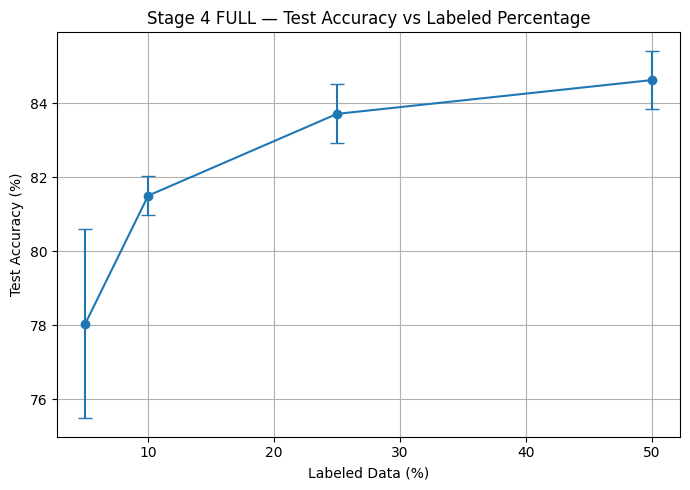

In [ ]:
def make_labeled_unlabeled_indices_from_pool(train_pool_dataset, labeled_fraction, seed=123):
    g = torch.Generator().manual_seed(seed)

    n_total = len(train_pool_dataset)
    n_labeled = int(round(labeled_fraction * n_total))
    n_unlabeled = n_total - n_labeled

    labeled_ds, unlabeled_ds = random_split(train_pool_dataset, [n_labeled, n_unlabeled], generator=g)

    pool_idx = train_pool_dataset.indices  
    labeled_idx = [pool_idx[i] for i in labeled_ds.indices]
    unlabeled_idx = [pool_idx[i] for i in unlabeled_ds.indices]

    return labeled_idx, unlabeled_idx

def set_stage4_loaders(labeled_idx, unlabeled_idx, batch_size=128):
    global labeled_loader, unlabeled_clean_loader, unlabeled_aug_loader

    labeled_aug = Subset(train_augmented, labeled_idx)
    labeled_loader = DataLoader(labeled_aug, batch_size=batch_size, shuffle=True)

    unlabeled_clean = Subset(train_minmax, unlabeled_idx)
    unlabeled_aug   = Subset(train_augmented, unlabeled_idx)

    unlabeled_clean_loader = DataLoader(unlabeled_clean, batch_size=batch_size, shuffle=False, drop_last=True)
    unlabeled_aug_loader   = DataLoader(unlabeled_aug,   batch_size=batch_size, shuffle=False, drop_last=True)

seeds = [1, 123, 12345]
labeled_fracs = [0.05, 0.10, 0.25, 0.50]

acc_means = []
acc_stds = []

for frac in labeled_fracs:
    labeled_idx, unlabeled_idx = make_labeled_unlabeled_indices_from_pool(
        train_pool_dataset, frac, seed=123
    )

    # Build loaders for this labeled fraction
    set_stage4_loaders(labeled_idx, unlabeled_idx, batch_size=128)

    # Run Stage 4 FULL across seeds
    runs = run_many(
        run_stage4_consistency_full,
        seeds,
        dropout_p=0.25,
        weight_decay=1e-3,
        lr=0.01,
        momentum=0.9,
        max_epochs=50,
        early_stop_window=5,
        lambda_max=1.0,     
        warmup_epochs=20,   
        verbose=False,
        save_dir="./results/stage4_full",
        save_model=True
    )

    mu, sd,_ = summarize_runs(runs)
    acc_means.append(mu)
    acc_stds.append(sd)

    print(f"Labeled {int(frac*100):>2d}% | Test Acc: {mu:.2f}% ± {sd:.2f}%")

# Plot: Test Accuracy vs % labeled
x = [int(f * 100) for f in labeled_fracs]

plt.figure(figsize=(7,5))
plt.errorbar(x, acc_means, yerr=acc_stds, fmt='o-', capsize=5)
plt.xlabel("Labeled Data (%)")
plt.ylabel("Test Accuracy (%)")
plt.title("Stage 4 FULL — Test Accuracy vs Labeled Percentage")
plt.grid(True)
plt.tight_layout()
plt.show()

## Stage 5D — Statistical Significance (Paired t-test)

We test whether improvements are statistically significant by comparing
test accuracies across the same seeds (paired design).

In [ ]:
# Statistical Significance (paired t-test)
import numpy as np
from scipy import stats

def paired_ttest_from_seeds(
    runner_A, kwargs_A,
    runner_B, kwargs_B,
    seeds=(1, 123, 12345),
    metric_key="test_acc"
):
    """
    Runs two runners on the same seeds and performs a paired t-test on metric_key.

    Returns:
        dict with means, stds, deltas, t-stat, p-value
    """
    A = []
    B = []

    for s in seeds:
        outA = runner_A(seed=s, **kwargs_A)
        outB = runner_B(seed=s, **kwargs_B)
        A.append(float(outA[metric_key]))
        B.append(float(outB[metric_key]))

    A = np.array(A)
    B = np.array(B)
    D = B - A

    # paired t-test (B vs A)
    t_stat, p_val = stats.ttest_rel(B, A)

    return {
        "seeds": list(seeds),
        "metric": metric_key,
        "A_values": A.tolist(),
        "B_values": B.tolist(),
        "A_mean": float(A.mean()),
        "A_std": float(A.std(ddof=1)),
        "B_mean": float(B.mean()),
        "B_std": float(B.std(ddof=1)),
        "delta_values": D.tolist(),
        "delta_mean": float(D.mean()),
        "delta_std": float(D.std(ddof=1)),
        "t_stat": float(t_stat),
        "p_value": float(p_val),
    }


# Baseline vs Dropout
seeds = [1, 123, 12345]

baseline_kwargs = dict(
    init_mode="he",
    lr=0.01,
    momentum=0.9,
    max_epochs=50,
    early_stop_window=5,
    verbose=False,
    save_dir="./results/stage2",
    save_model=True
)

dropout_kwargs = dict(
    dropout_p=0.25,
    init_mode="he",
    lr=0.01,
    momentum=0.9,
    max_epochs=50,
    early_stop_window=5,
    verbose=False,
    save_dir="./results/stage3_dropout",
    save_model=True
)

res = paired_ttest_from_seeds(
    runner_A=run_stage2, kwargs_A=baseline_kwargs,
    runner_B=run_stage3_dropout, kwargs_B=dropout_kwargs,
    seeds=seeds,
    metric_key="test_acc"
)

print("Paired t-test: Dropout vs Baseline")
print(f"A (Baseline) mean ± std : {res['A_mean']:.2f} ± {res['A_std']:.2f}")
print(f"B (Dropout)  mean ± std : {res['B_mean']:.2f} ± {res['B_std']:.2f}")
print(f"Δ (B-A) mean ± std      : {res['delta_mean']:.2f} ± {res['delta_std']:.2f}")
print(f"t = {res['t_stat']:.4f},  p = {res['p_value']:.6f}")


# Example 2: CORE vs FULL 
core_kwargs = dict(
    lr=0.01,
    momentum=0.9,
    max_epochs=50,
    early_stop_window=5,
    lambda_max=1.0,
    warmup_epochs=20,
    verbose=False,
    save_dir="./results/stage4_core",
    save_model=True
)

full_kwargs = dict(
    dropout_p=0.25,
    weight_decay=1e-3,
    lr=0.01,
    momentum=0.9,
    max_epochs=50,
    early_stop_window=5,
    lambda_max=1.0,
    warmup_epochs=20,
    verbose=False,
    save_dir="./results/stage4_full",
    save_model=True
)

res2 = paired_ttest_from_seeds(
    runner_A=run_stage4_consistency_core, kwargs_A=core_kwargs,
    runner_B=run_stage4_consistency_full, kwargs_B=full_kwargs,
    seeds=seeds,
    metric_key="test_acc"
)

print("\nPaired t-test: Stage4 FULL vs Stage4 CORE")
print(f"A (CORE) mean ± std : {res2['A_mean']:.2f} ± {res2['A_std']:.2f}")
print(f"B (FULL) mean ± std : {res2['B_mean']:.2f} ± {res2['B_std']:.2f}")
print(f"Δ (B-A) mean ± std  : {res2['delta_mean']:.2f} ± {res2['delta_std']:.2f}")
print(f"t = {res2['t_stat']:.4f},  p = {res2['p_value']:.6f}")



STAGE 2 RUN CONFIG
----------------------------------------------------------------------
Run ID            : stage2_seed1_inithe_lr0.01_m0.9_win5
Seed              : 1
Init              : he
Learning rate     : 0.01
Momentum          : 0.9
Max epochs        : 50
Early-stop window : 5


STAGE 3 (DROPOUT) RUN CONFIG
----------------------------------------------------------------------
Run ID            : stage3drop_seed1_p0.25_inithe_lr0.01_m0.9_win5
Seed              : 1
Dropout p         : 0.25
Init              : he
Learning rate     : 0.01
Momentum          : 0.9
Max epochs        : 50
Early-stop window : 5


STAGE 2 RUN CONFIG
----------------------------------------------------------------------
Run ID            : stage2_seed123_inithe_lr0.01_m0.9_win5
Seed              : 123
Init              : he
Learning rate     : 0.01
Momentum          : 0.9
Max epochs        : 50
Early-stop window : 5


STAGE 3 (DROPOUT) RUN CONFIG
--------------------------------------------------------